In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.collections import PatchCollection
import math
import time
# For the colorcet set of colours use `pip install colorcet`
import colorcet
matplotlib.rcParams['text.latex.preamble']=[r"\usepackage{amsmath}"]
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from colorsys import rgb_to_hls, hls_to_rgb
from sklearn.linear_model import LinearRegression

In [46]:
#########################################
############### FUNCTIONS ###############
#########################################

def density_buried(corner,R,R_buried,buried_depth,rho0,rho1,h_x,h_y=None,h_z=None):
    """Assigns a density when given the coordinates of a cell. As in the other functions these coordinates are of the 
    smallest corner of the cell. The density is built according to the model of a buried prism. The assigned density is 
    determined by the density of the original model at the centre of the cell. The dimensions of the cell need to be given.
    If only a dimension for the x-axis is given, the cell is assumed to be cubic. 
    The location is determined by using a formula describing an interval. For example for x the formula is 
    -(x-R/2)**2 + (R_buried/2)**2
    This describes an interval on the x-axis around R/2 of length R_buried. So the result is that the buried prism lies
    around the middle of the box, with its assigned dimensions. 
    INPUT:
        corner       --> array containing the coordinates of the cell (3,) [m]
        R            --> size of the total (cubic) box [m]
        R_buried     --> size of the cubic prism [m]
        buried_depth --> the distance from the top of the buried prism to the top of the box [m]
        rho0         --> density of the surrounding material [kg/m^3]
        rho1         --> density of the buried prism [kg/m^3]
        h_x          --> dimensions of the cell in the x-direction [m]
    OPTIONAL:
        h_y          --> dimensions of the cell in the y-direction. if not supplied, assumed to be the same as h_x [m]
        h_z          --> dimensions of the cell in the z-direction. if not supplied, assumed to be the same as h_x [m]
    
    RESULTS:
        rho0 or rho1 --> depending on the location of the centre of the cell, one of the densities is returned 
    """
    # If they are not provided, they are just the same as h_x, so if only h_x is given, the cell is a cube
    if h_y == None:
        h_y = h_x
    if h_z == None:
        h_z = h_x
    
    # The x,y and z coordinates of the centre of the cell
    x = corner[0] + 0.5*h_x
    y = corner[1] + 0.5*h_y
    z = corner[2] + 0.5*h_z
    
    # These give intervals of length R_buried around R/2 on the x and y axis and around R - buried_depth - R_buried on the
    # z-axis
    if -(x-R/2)**2 + (R_buried/2)**2 >= 0 and -(y-R/2)**2 + (R_buried/2)**2 >= 0 and -(z-R+buried_depth+R_buried/2)**2 + (R_buried/2)**2 >= 0:
        return rho1
    else:
        return rho0

# Extracting the information of the AK135 model from the text file
AK135 = np.reshape(np.fromfile(file = "AK135 vel.txt", sep = ";", count = -1), (146, 7)) 
depths = AK135[::-1,0]*1000
densities = AK135[::-1,1]*1000
# Converting the depths into distances from the core
for i in range(len(depths)):
    depths[i] = 6371e3 - depths[i]
# The function interpolates between the given values of the density

def density_sphere(corner,h_x, mode, h_y=None,h_z=None,rho0 = 3000):
    """ Assigns a density when given the coordinates of a cell. As in the other functions these coordinates are of the 
    smallest corner of the cell. The density is built according to the model of a sphere. The assigned density is 
    determined by the density of the original model at the centre of the cell. The dimensions of the cell need to be given.
    If only a dimension for the x-axis is given, the cell is assumed to be cubic. 
    There are a few options for the density model of the sphere:
    hom - uses a homogeneous density for the whole sphere. If the cell-centre is inside the sphere the density assigned 
          is the variable rho0.
    PREM - assigns a density according to the PREM model. This uses a set of equations of curves. The density is given
           by putting in the radius into the right equation.
    AK135 - assigns a density according to the AK135 model. This uses data fetched from the file AK135 vel.txt. It 
            it interpolates between the density values using the depth values. The extracting of information is done
            above the function.
    
    INPUT:
        corner       --> array containing the coordinates of the cell (3,) [m]
        h_x          --> dimensions of the cell in the x-direction [m]
        mode         --> string showing which density structure is used, options are 'hom','PREM','AK135'
    OPTIONAL:
        h_y          --> dimensions of the cell in the y-direction. if not supplied, assumed to be the same as h_x [m]
        h_z          --> dimensions of the cell in the z-direction. if not supplied, assumed to be the same as h_x [m]
        rho0         --> the density used by the hom density structure. does not need to be put in if another method is
                         used [kg/m^3]
    
    RESULTS:
        density      --> density as determined by the density model of choice [kg/m^3]
    """
    # If they are not provided, they are just the same as h_x, so if only h_x is given, the cell is a cube
    if h_y == None:
        h_y = h_x
    if h_z == None:
        h_z = h_x
    
    # The distance from the core is determined with the centre of the cell
    radius = np.sqrt((corner[0]+0.5*h_x)**2+(corner[1]+0.5*h_y)**2+(corner[2]+0.5*h_z)**2)
    
    if mode == "hom":
        # If the sphere has a homogeneous density, the density should give rho0 if the centre is inside the sphere, 
        # otherwise it should be zero
        if radius < 6371e3:
            return rho0
        else:
            return 0
    if mode == "PREM":
        # The radius is converted to a fraction of the radius and that is used in formulas describing the PREM model as
        # curves
        x=radius/6371.0e3
        if radius>6371.0e3:
            densprem=0
        elif radius<=1221.5e3:
            densprem=13.0885-8.8381*x**2
        elif radius<=3480.0e3:
            densprem=12.5815-1.2638*x-3.6426*x**2-5.5281*x**3
        elif radius<=3630.0e3:
            densprem=7.9565-6.4761*x+5.5283*x**2-3.0807*x**3
        elif radius<=5600.0e3:
            densprem=7.9565-6.4761*x+5.5283*x**2-3.0807*x**3
        elif radius<=5701.0e3:
            densprem=7.9565-6.4761*x+5.5283*x**2-3.0807*x**3
        elif radius<=5771.0e3:
            densprem=5.3197-1.4836*x
        elif radius<=5971.0e3:
            densprem=11.2494-8.0298*x
        elif radius<=6151.0e3:
            densprem=7.1089-3.8045*x
        elif radius<=6291.0e3:
            densprem=2.6910+0.6924*x
        elif radius<=6346.0e3:
            densprem=2.6910+0.6924*x
        elif radius<=6356.0e3:
            densprem=2.9
        elif radius<=6368.0e3:
            densprem=2.6
        else:
            densprem=1.020
        return densprem*1000
    if mode == "AK135":
        # This interpolates between the data from AK135 as given in the txt file. 
        return np.interp(radius,depths,densities)

def grav_calc(prism,obs_point,method,rho,h_x,h_y=None,h_z=None, use_num_stab = False):
    """ The gravity calculations of a single cell on one observation point according to a chosen method. The cell always
    has a homogeneous density. 
    For the point mass method all of the mass of the cell is assumed to be concentrated in the centre of the cell. For
    the prism method The gravitational response is integrated over the volume of the prism. The first is more time 
    efficient, while the second is more accurate. 
    The coordinates of the cell must be given as the corner with the smallest coordinates. For example in the cube with 
    corners (1,1,1) and (5,5,5), the first coordinate must be given. The dimensions of the cell are assumed to be cubic
    if only the length on the x-axis is given.
    
    INPUT:
        prism     --> the coordinates of the cell used (3,) [m]
        obs_point --> the coordinates of the observation point used (3,) [m]
        method    --> which method of calculation to use, can be 'prism' or 'point'
        rho       --> the density of the cell [kg/m^3]
        h_x       --> dimensions of the cell in the x-direction [m]
    OPTIONAL:
        h_y       --> dimensions of the cell in the y-direction. if not supplied, assumed to be the same as h_x [m]
        h_z       --> dimensions of the cell in the z-direction. if not supplied, assumed to be the same as h_x [m]
        use_num_stab --> whether or not to use the extra numerical stability gotten from Heck and Seitz, 2007
        
    RESULTS:
        U         --> the gravitational potential [J/kg]
        g         --> the gravity vector (3,) [m/s^2]
        T         --> the gravity gradient tensor (3,3) [s^-2]
    """
    
    # Converting the given corner of the cell to the observation coordinate system
    coords = prism - obs_point
    
    # If they are not provided, they are just the same as h_x, so if only h_x is given, the cell is a cube
    if h_y == None:
        h_y = h_x
    if h_z == None:
        h_z = h_x
    
    G = 6.6738480e-11 # gravitational constant [m^3 s^-2 kg^-1]
    
    U_calc = 0.
    g_calc = np.zeros(3,dtype=np.float64)
    T_calc = np.zeros([3,3],dtype=np.float64)
    
    if method == "point":
        # The coordinates needed are at the point mass in the centre of the cell
        x = coords[0] + 0.5*h_x
        y = coords[1] + 0.5*h_y
        z = coords[2] + 0.5*h_z
    
        # calculating the distance between the observation point and the point mass
        r = np.sqrt(x**2+y**2+z**2)
        # The volume of the cell
        dV = h_x*h_y*h_z

        # calculating the different values
        U_calc = -G * rho * dV / r
        g_calc = G * rho * dV * x / r**3, G * rho * dV * y / r**3, G * rho * dV * z / r**3

        T_calc[0,0] = -G*rho*dV*(3*x**2-r**2)/r**5
        T_calc[1,1] = -G*rho*dV*(3*y**2-r**2)/r**5
        T_calc[2,2] = -G*rho*dV*(3*z**2-r**2)/r**5
        T_calc[0,1] = -G*rho*dV*3*x*y/r**5
        T_calc[1,0] = T_calc[0,1]
        T_calc[0,2] = -G*rho*dV*3*x*z/r**5
        T_calc[2,0] = T_calc[0,2]
        T_calc[1,2] = -G*rho*dV*3*y*z/r**5
        T_calc[2,1] = T_calc[1,2]
    
    elif method == "prism":
        # The coordinates needed are the boundaries. For example (1,1,1) and (5,5,5)
        x = [coords[0],coords[0]+h_x]
        y = [coords[1],coords[1]+h_y]
        z = [coords[2],coords[2]+h_z]

        # The triple summation is implemented as a triple loop
        for i in range(2):
            for j in range(2):
                for k in range(2):
                    # The distance between the observation point and the integration point is calculated
                    r = np.sqrt(x[i]**2+y[j]**2+z[k]**2)

                    # There are cases where the calculations will fail, f.e. log(0) or arctan(1/0). To stop this, exception
                    # cases are defined. They are set to the limit values, so log(0) -> 0 and arctan(1/0) -> 1/2 pi
                    if x[i] == 0:
                        arctan_x = - 0.5*np.pi
                    else:
                        arctan_x = - np.arctan((y[j]*z[k]/(x[i]*r)))
                    if y[j] == 0:
                        arctan_y = - 0.5*np.pi
                    else:
                        arctan_y = - np.arctan((x[i]*z[k]/(y[j]*r)))
                    if z[k] == 0:
                        arctan_z = - 0.5*np.pi
                    else:
                        arctan_z = - np.arctan((x[i]*y[j]/(z[k]*r)))

                    # Along with the exceptions, there is a variant of the equations that should offer extra numerical 
                    # stability. This can be turned on if wanted
                    if r+x[i] == 0:
                        log_x = 0
                    else:
                        if use_num_stab == False:
                            log_x = np.log(x[i]+r)
                        else:
                            log_x = np.log((x[i]+r)/(np.sqrt(y[j]**2+z[k]**2)))
                    if r+y[j] == 0:
                        log_y = 0
                    else:
                        if use_num_stab == False:
                            log_y = np.log(y[j]+r)
                        else:
                            log_y = np.log((y[j]+r)/(np.sqrt(x[i]**2+z[k]**2)))
                    if r+z[k] == 0:
                        log_z = 0
                    else:
                        if use_num_stab == False:
                            log_z = np.log(z[k]+r)
                        else:
                            log_z = np.log((z[k]+r)/(np.sqrt(x[i]**2+y[j]**2)))

                    U_calc += (-1)**(i+j+k) * (y[j]*z[k]*log_x + x[i]*y[j]*log_z  + x[i]*z[k]*log_y 
                                           + x[i]**2/2*arctan_x + y[j]**2/2*arctan_y + z[k]**2/2*arctan_z
                                          )

                    g_calc[0] += (-1)**(i+j+k) * (z[k]*log_y + y[j]*log_z + x[i]*arctan_x)
                    g_calc[1] += (-1)**(i+j+k) * (z[k]*log_x + x[i]*log_z + y[j]*arctan_y)
                    g_calc[2] += (-1)**(i+j+k) * (x[i]*log_y + y[j]*log_x + z[k]*arctan_z)

                    T_calc[0,0] += (-1)**(i+j+k) * arctan_x
                    T_calc[1,1] += (-1)**(i+j+k) * arctan_y
                    T_calc[2,2] += (-1)**(i+j+k) * arctan_z
                    T_calc[0,1] += (-1)**(i+j+k) * log_z
                    T_calc[1,0] = T_calc[0,1]
                    T_calc[0,2] += (-1)**(i+j+k) * log_y
                    T_calc[2,0] = T_calc[0,2]
                    T_calc[1,2] += (-1)**(i+j+k) * log_x
                    T_calc[2,1] = T_calc[1,2]
        # When the summations are complete, everything is multiplied with G and rho to get the final values
        U_calc *= G*rho
        g_calc *= G*rho
        T_calc *= G*rho
    
    # The results are returned
    return U_calc, g_calc, T_calc

def grav_calc_analyt_sphere(obs_points,rho):
    """ The analytical solution to the gravitation response of the model of a sphere. This is only possible for the model
    of homogeneous density. The calculations can be done for multiple observation points. This needs to be supplied in an 
    array of the form (M,3), where M is the amount of observation points. If there is only a single observation point, the
    array will automatically take the shape (3,). This can be solved by supplying the array as obs_point[np.newaxis,:]. 
    This takes the form (1,3).
    
    INPUT:
        obs_points --> array containing the coordinates of the observation points, shape is discussed above (M,3) [m]
        rho        --> density of the sphere [kg/m^3]
    
    RESULTS:
        U_th       --> the gravitational potential (M,) [J/kg]
        g_th       --> the gravity vector (M,3) [m/s^2]
        T_th       --> the gravity gradient tensor (M,3,3) [s^-2]
    """
    R = 6.371e6 # the radius of the sphere, the same as Earth's radius [m]
    G = 6.6738480e-11 # gravitational constant [m^3 s^-2 kg^-1]
    vol_th = 4/3*np.pi*R**3 # the volume of the sphere [m^3]
    
    # The distance between each observation point and the centre of the sphere
    r = np.sqrt(obs_points[:,0]**2+obs_points[:,1]**2+obs_points[:,2]**2)
    
    g_th = np.zeros([len(obs_points),3])
    
    # Calculating all of the values
    U_th = -G*vol_th*rho0/r
    g_th = np.array([-G*vol_th*rho0*obs_points[:,0]/r**3, 
                     -G*vol_th*rho0*obs_points[:,1]/r**3, 
                     -G*vol_th*rho0*obs_points[:,2]/r**3])
    # The axes are swapped so that the result is (M,3) instead of (3,M)
    g_th = np.swapaxes(g_th,0,1)
    
    T_th = np.empty([len(obs_points),3,3])
    
    T_th[:,0,0] = -G*rho*vol_th*(3*obs_points[:,0]**2-r**2)/r**5
    T_th[:,1,1] = -G*rho*vol_th*(3*obs_points[:,1]**2-r**2)/r**5
    T_th[:,2,2] = -G*rho*vol_th*(3*obs_points[:,2]**2-r**2)/r**5
    T_th[:,0,1] = -G*rho*vol_th*3*obs_points[:,0]*obs_points[:,1]/r**5
    T_th[:,1,0] = T_th[:,0,1]
    T_th[:,0,2] = -G*rho*vol_th*3*obs_points[:,0]*obs_points[:,2]/r**5
    T_th[:,2,0] = T_th[:,0,2]
    T_th[:,1,2] = -G*rho*vol_th*3*obs_points[:,1]*obs_points[:,2]/r**5
    T_th[:,2,1] = T_th[:,1,2]
    
    return U_th,g_th,T_th

def grav_calc_analyt_buried(R,R_buried,buried_depth,obs_points,rho0,rho1):
    """ The analytical solution to the gravitational response according to the model of a buried prism. The calculations 
    can be done for multiple observation points. This needs to be supplied in an array of the form (M,3), where M is the 
    amount of observation points. If there is only a single observation point, the array will automatically take the 
    shape (3,). This can be solved by supplying the array as obs_point[np.newaxis,:]. This takes the form (1,3). The 
    calculations are done using the analytical solution for a prism with the size of the total box and the density of 
    the surrounding material. Then the buried prism is subtracted from that and added with the right density. This 
    subtraction/addition works because of the superposition principle of the gravitational field. 
    
    INPUT:
        R            --> size of the total (cubic) box [m]
        R_buried     --> size of the cubic buried prism [m]
        buried_depth --> the distance from the top of the buried prism to the top of the box [m]
        obs_points   --> array containing the coordinates of the observation points, shape is discussed above (M,3) [m]
        rho0         --> density of the surrounding material [kg/m^3]
        rho1         --> density of the buried prism [kg/m^3]
    
    RESULTS:
        U_th       --> the gravitational potential (M,) [J/kg]
        g_th       --> the gravity vector (M,3) [m/s^2]
        T_th       --> the gravity gradient tensor (M,3,3) [s^-2]
    """
    
    M = len(obs_points) # the amount of observation points
    
    U_th = np.zeros([M],dtype = np.float64)
    g_th = np.zeros([M,3],dtype = np.float64)
    T_th = np.zeros([M,3,3],dtype = np.float64)
    
    # The analytical gravitational response of a prism is already determined with grav_calc and method 'prism', so that 
    # can be used
    for k in range(M):
        # For the irregular shape of a buried prism, the superposition principle can be used. The sum of every part of the
        # box as if they had the same density is
        U_big, g_big, T_big = grav_calc(np.array([0,0,0]),obs_points[k,:],'prism',rho0,R)
        # Now the part with the buried prism is not correct, so that should be removed
        U_bad, g_bad, T_bad = grav_calc(np.array([0.5*R-0.5*R_buried,0.5*R-0.5*R_buried,R-buried_depth-R_buried]),obs_points[k,:],'prism',rho0,R_buried) 
        # and the new part with the correct density should be used instead
        U_lit, g_lit, T_lit = grav_calc(np.array([0.5*R-0.5*R_buried,0.5*R-0.5*R_buried,R-buried_depth-R_buried]),obs_points[k,:],'prism',rho1,R_buried) 
        
        # The correction from above is applied
        U_th[k] = U_big - U_bad + U_lit
        g_th[k,:] = g_big - g_bad + g_lit
        T_th[k,:,:] = T_big - T_bad + T_lit
    
    return U_th, g_th, T_th

# A simple function that converts an amount of seconds to hours, minutes, seconds
def time_converter(total_seconds):
    """ A simple function that prints the amount of hours, minutes and seconds that a given amount of seconds represents.
    This is more convenient for large numbers.
    
    INPUT:
        total_seconds --> the amount of seconds that must be converted [s]
    
    RESULTS:
    """
    
    hours = int(total_seconds / 3600)
    minutes = int(total_seconds%3600 / 60)
    seconds = total_seconds % 60
    
    print(hours, "h.", minutes, "m.", round(seconds,5), "s.")

def full_calc(corners,obs_points,method,rho,h_x,h_y=None,h_z=None, num_stab = False, tracking = False):
    """ The basic function calculating the gravitational response when given a location model and a set of observation
    points using a chosen method. The coordinates of every cell in the model are given in an array of size (NP,3). These
    need to be the coordinates of the smallest corner of the cell. This means that for a cell with outer coordinates
    (1,1,1) and (6,6,3), the first must be given. The density of every cell is given in a respective array of size (NP,).
    Multiple observation points can be used. This needs to be supplied in an array of the form (M,3), where M is the 
    amount of observation points. If there is only a single observation point, the array will automatically take the shape 
    (3,), which does not work. This can be solved by supplying the array as obs_point[np.newaxis,:]. This takes the 
    form (1,3).
    
    INPUT:
        corners    --> the coordinates of the corners of every prism in the model (NP,3) [m]
        obs_points --> the coordinates of every observation point (M,3) [m]
        method     --> which method of calculation to use, can be 'prism' or point
        rho        --> the density of every prism in the model respective to the corners array (NP,) [kg/m^3]
        h_x        --> dimensions of each prism in the x-direction [m]
    OPTIONAL:
        h_y        --> dimensions of each prism in the y-direction. if not supplied, assumed to be the same as h_x [m]
        h_z        --> dimensions of each prism in the z-direction. if not supplied, assumed to be the same as h_x [m]
        num_stab   --> whether or not to use the equations providing extra numerical stability from Heck and Seitz, 2007
        tracking   --> it is possible to track the progress of observation points, this is not advised for N < 15
        
    RESULTS:
        U          --> the gravitational potential (M,) [J/kg]
        g          --> the gravity vector (M,3) [m/s^2]
        T          --> the gravity gradient tensor (M,3,3) [s^-2]
    
    """
    G = 6.6738480e-11 # gravitational constant [m^3 s^-2 kg^-1]
    
    M = len(obs_points) # the amount of observation points
    
    # The total amount of cells is interpreted from the length of corners
    NP = len(corners)
    
    # These will contain the values of U and g
    U = np.zeros(M, dtype = np.float64)
    g = np.zeros([M,3],dtype=np.float64)
    T = np.zeros([M,3,3],dtype=np.float64)
    
    # A loop for every observation point
    for k in range(M):
        # And one for every prism
        for l in range(NP):
            # Getting the contribution of this prism with the prism calculations
            U_dum, g_dum, T_dum = grav_calc(corners[l,:],obs_points[k,:],method,rho[l],h_x,h_y,h_z, use_num_stab = num_stab)
            
            # Adding it to the total for this observation point
            U[k] += U_dum
            g[k,:] += g_dum
            T[k,:,:] += T_dum
            
        # This prints how many observation points are done, it prints over itself so as not to clutter the output
        if tracking == True:
            print("Finished with observation point", k+1, "of", M, end="\r", flush=True)
    # Enter a new line after the progress line
    if tracking == True:
        print("")
        
    # Return the results
    return U,g,T

def imshow_U_g(U,g,N,geometry,method,U_min = None,U_max = None,g_xy_min = None,g_xy_max = None,g_z_min = None,g_z_max = None):
    """ A function generating the plots for the gravitational potential and components of the gravity vector over a 2D 
    observation grid. Creates four images 2x2 with description. This observation grid has (M_x,M_y) observation points. 
    The image uses a visually homogeneous colormap with contour lines of a slightly darker colour added to them.
    The limits of each plot can be set manually to have plots where the same colour corresponds to the same value in 
    different images. Can also be ignored. The result is saved as a .png in ./gravity_field/
    
    INPUT:
        U        --> the gravitational potential that needs to be shown (M_x,M_y) [J/kg]
        g        --> the gravity vector that needs to be shown (M_x,M_y,3) [m/s^2]
        N        --> the value of N (amount of cells on one axis) used in the model, given in the file name for 
                     identification purposes
        geometry --> the geometry used to calculate the gravitational response. used to determine the limits of the picture
        method   --> the method used to calculate the gravitational response. it is a string used directly in the file name
    OPTIONAL:
        U_min    --> the value of U that is set as the minimum of the colormap
        U_max    --> the value of U that is set as the maximum of the colormap
        g_xy_min --> the value of the x and y components of g that is set as the minimum of the colormap
        g_xy_max --> the value of the x and y components of g that is set as the maximum of the colormap
        g_z_min  --> the value of the z component of g that is set as the minimum of the colormap
        g_z_max  --> the value of the z component of g that is set as the maximum of the colormap
    
    RESULTS:
        a .png image saved at the file storage
        the images are shown in the output
    """
    # The font size
    plt.rc('font', size=15)
    
    # If the limits of the colour scale are not defined, they are calculated here
    if U_min == None:
        U_min = U.min()
    if U_max == None:
        U_max = U.max()
    if g_xy_min == None:
        g_xy_min = g[:,0:2].min()
    if g_xy_max == None:
        g_xy_max = g[:,0:2].max()
    if g_z_min == None:
        g_z_min = g[:,2].min()
    if g_z_max == None:
        g_z_max = g[:,2].max()
    
    # The different geometries have different limits of the box. These are defined here
    if geometry == "SPHERE":
        R = 6.371e6
        limits = [-R/1e6,R/1e6,-R/1e6,R/1e6]
        unit = "Mm"
    elif geometry == "BURIED":
        R = 1000
        limits = [0,R/1000,0,R/1000]
        unit = "km"
    elif geometry == 'SALT':
        R_x = 2940.0
        R_y = 2100.0
        limits = [0,R_x,0,R_y]
        unit = 'm'
    
    # The colormap is defined, this is a rainbow that should be perceptually uniform
    colormap_used = "cet_diverging_rainbow_bgymr_45_85_c67" # cet_rainbow_bgyrm_35_85_c69_r
    # A darker version of the colormap is made for the contour lines
    colormap_contours = darker_colormap(colorcet.CET_R3, factor = 0.3)
    
    M = len(U) # the amount of observation points is interpreted from the size of the data arrays
    
    # Initiating a plot with 4 subplots 2x2 and size 10,10
    fig, axs = plt.subplots(2, 2,figsize=(10,10))
    
    # The first subplot with U
    ax = axs[0,0]
    colbar = axs[0,0].imshow(U.T, cmap = colormap_used, origin = "lower", extent=limits)
    axs[0,0].set_title("U (Jkg$^{-1}$)")
    fig.colorbar(colbar, ax=ax, fraction=0.046, pad=0.04)
    ax.contour(U.T, extent=limits, cmap=colormap_contours, origin = "lower")
    
    # The second subplot with g_x
    ax = axs[0,1]
    colbar = axs[0,1].imshow(g[:,:,0].T, cmap = colormap_used, origin = "lower", vmin = g_xy_min, vmax = g_xy_max, extent=limits)
    axs[0,1].set_title("g$_x$ (m/s$^{-2}$)")
    fig.colorbar(colbar, ax=ax, fraction=0.046, pad=0.04)
    ax.contour(g[:,:,0].T, extent=limits, cmap=colormap_contours,origin = "lower", vmin = g_xy_min, vmax = g_xy_max)
    
    # The third subplot with g_y
    ax = axs[1,0]
    colbar = axs[1,0].imshow(g[:,:,1].T, cmap = colormap_used, origin = "lower", vmin = g_xy_min, vmax = g_xy_max, extent=limits)
    axs[1,0].set_title("g$_y$ (m/s$^{-2}$)")
    fig.colorbar(colbar, ax=ax, fraction=0.046, pad=0.04)
    ax.contour(g[:,:,1].T, extent=limits, cmap=colormap_contours,origin = "lower", vmin = g_xy_min, vmax = g_xy_max)
    
    # The fourth subplot with g_z
    ax = axs[1,1]
    colbar = axs[1,1].imshow(g[:,:,2].T, cmap = colormap_used, origin = "lower", vmin = g_z_min, vmax = g_z_max, extent=limits)
    axs[1,1].set_title("g$_z$ (m/s$^{-2}$)")
    fig.colorbar(colbar, ax=ax, fraction=0.046, pad=0.04)
    ax.contour(g[:,:,2].T, extent=limits, cmap=colormap_contours,origin = "lower", vmin = g_z_min, vmax = g_z_max)
    
    # The labels for the axes are set
    fig.tight_layout()
    for ax in axs.flat:
        ax.set(xlabel='x (%s)'%(unit), ylabel='y (%s)'%(unit))
    
    # Hide x labels and tick labels for top plots and y ticks for right plots. Does not work anymore, do not know why
    for ax in axs.flat:
        ax.label_outer()
    # The result is saved
    plt.savefig('./gravity_field/%s - gravity_fields_N_%s_M_%s_U_g - %s.png'%(geometry,N,M,method), dpi=200)
    # And shown in the output
    plt.show()
    
def imshow_T(T,N,geometry,method,T_min=None,T_max=None):
    """ A function generating the plots for the gravity gradient tensor components over a 2D 
    observation grid. Creates four images 2x2 with description. This observation grid has (M_x,M_y) observation points. 
    The image uses a visually homogeneous colormap with contour lines of a slightly darker colour added to them.
    The limits of each plot can be set manually to have plots where the same colour corresponds to the same value in 
    different images. Can also be ignored. The result is saved as a .png in ./gravity_field/
    
    Note that the unit used for the images is Eotvos, while the arrays supplied are in s^-2!
    
    INPUT:
        T        --> the gravitaty gradient response that needs to be shown (M_x,M_y,3,3) [s^-2]
        N        --> the value of N (amount of cells on one axis) used in the model, given in the file name for 
                     identification purposes
        geometry --> the geometry used to calculate the gravitational response. used to determine the limits of the picture
        method   --> the method used to calculate the gravitational response. it is a string used directly in the file name
    OPTIONAL:
        T_min    --> the value of T that is set as the minimum of the colormap
        T_max    --> the value of T that is set as the maximum of the colormap
    
    RESULTS:
        a .png image saved at the file storage
        the images are shown in the output
    """
    
    # The font size
    plt.rc('font', size=15)
    
    # If the limits of the colour scale are not defined, they are calculated here
    if T_min == None:
        T_min = T.min()*1e9
    if T_max == None:
        T.max()*1e9

    # The different geometries have different limits of the box. These are defined here
    if geometry == "SPHERE":
        R = 6.371e6
        limits = [-R/1e6,R/1e6,-R/1e6,R/1e6]
        unit = "Mm"
    elif geometry == "BURIED":
        R = 1000
        limits = [0,R/1000,0,R/1000]
        unit = "km"
    elif geometry == 'SALT':
        R_x = 2940.0
        R_y = 2100.0
        limits = [0,R_x,0,R_y]
        unit = 'm'
    
    # The colormap is defined, this is a rainbow that should be perceptually uniform
    colormap_used = "cet_diverging_rainbow_bgymr_45_85_c67" # cet_rainbow_bgyrm_35_85_c69_r
    # A darker version of the colormap is made for the contour lines
    colormap_contours = darker_colormap(colorcet.CET_R3, factor = 0.3)
    
    # Each element of the tensor has an index showing its location, this is used for the title
    namen = ['x','y','z']
    
    M = len(T) # The amount of observation points is interpreted from the length of T
    
    # Setting up a plot with 9 subplots 3x3 and of size 20x20
    fig, axs = plt.subplots(3, 3,figsize=(20,20))
    
    # Starting a loop for every element on the first axis of the tensor
    for i in range(3):
        # Starting a loop for every element on the second axis of the tensor
        for j in range(3):
            # Making the image of the element, the gravity gradient is expressed in Eotvos
            ax = axs[i,j]
            colbar = axs[i,j].imshow(T[:,:,i,j].T*1e9, cmap = colormap_used, origin = "lower", vmin = T_min, vmax = T_max, extent=limits)
            axs[i,j].set_title("$T_{%s %s}$ (Eotvos)" % (namen[i], namen[j]))
            ax.contour(T[:,:,i,j].T*1e9, extent=limits, origin = "lower", cmap=colormap_contours, vmin = T_min, vmax = T_max)
            fig.colorbar(colbar, ax=ax, fraction=0.046, pad=0.04)
    
    # Setting the labels of the axes
    fig.tight_layout()
    for ax in axs.flat:
        ax.set(xlabel='x (%s)'%(unit), ylabel='y (%s)'%(unit))

    # Hide x labels and tick labels for top plots and y ticks for right plots. Does not work anymore
    for ax in axs.flat:
        ax.label_outer()
    # Saving the resulting plot
    plt.savefig('./gravity_field/%s - gravity_fields_N_%s_M_%s_T - %s.png'%(geometry,N,M, method), dpi=200)
    # Showing the resulting plot in the output
    plt.show()

def extreme_finder(array_prism,array_point,array_th):
    """ Finds the extremes of a set of three arrays. Intended use is to get the maximum values for gravitational 
    calculations with the point mass, prism methods and the analytical solution. This way when the colormap is generated,
    the same colour corresponds to the same value. This is important in being able to compare these images.
    
    INPUT:
        array_prism --> array containing the values using the prism approach - order of the methods does not actually 
                        matter
        array_point --> array containing the values using the point mass approach
        array_th    --> array containing the values according to the analytical solution
        
    RESULTS:
        minimum     --> the minimum value found in the three supplied arrays
        maximum     --> the maximum value found in the three supplied arrays
    """
    
    maximum = np.array([array_prism.max(),array_point.max(),array_th.max()]).max()
    minimum = np.array([array_prism.min(),array_point.min(),array_th.min()]).min()
    
    return minimum,maximum

def adjust_color_lightness(r, g, b, factor):
    """ A function gotten online that adjusts the lightness of a rgb colour. A factor of one means no change, higher is
    lighter, while lower means darker. Source:
    https://news.ycombinator.com/item?id=3583564
    
    INPUT:
        r      --> red value of the rgb scale
        g      --> green value of the rgb scale
        b      --> blue value of the rgb scale
        factor --> the factor by which the colour is changed, a higher value means lighter and one is neutral
        
    RESULTS:
        r      --> new red value
        g      --> new green value
        b      --> new blue value
    """
    # Converting the rbg to hls
    h, l, s = rgb_to_hls(r / 255.0, g / 255.0, b / 255.0)
    # Changing the lightness
    l = max(min(l * factor, 1.0), 0.0)
    # Converting back to rgb
    r, g, b = hls_to_rgb(h, l, s)
    return int(r * 255), int(g * 255), int(b * 255)

def darken_color(r, g, b, factor=0.1):
    """ An adapted version of the colour lightness changer that darkens colours. The factor means the amount that the 
    colour is darkened, where zero is no change. Source:
    https://news.ycombinator.com/item?id=3583564
    
    INPUT: 
        r      --> red value of the rgb scale
        g      --> green value of the rgb scale
        b      --> blue value of the rgb scale
        factor --> the factor by which the colour is changed, 0 is unchanged, higher is more change
        
    RESULTS:
        r      --> darker red value
        g      --> darker green value
        b      --> darker blue value
    """
    return adjust_color_lightness(r, g, b, 1 - factor)

def hex_to_rgb(value):
    """ Changes a hex colour value to the rgb format. Source:
    https://stackoverflow.com/questions/29643352/converting-hex-to-rgb-value-in-python
    
    INPUT:
        value --> the hex value that needs to be converted
    
    RESULTS:
        rgb   --> a tuple containing the rgb values
    """
    value = value.lstrip('#')
    lv = len(value)
    return tuple(int(value[i:i + lv // 3], 16) for i in range(0, lv, lv // 3))

def rgb_to_hex(rgb):
    """ Changes a rgb colour value to the hex format. Source:
    https://stackoverflow.com/questions/29643352/converting-hex-to-rgb-value-in-python
    
    INPUT: 
        rgb --> a tuple containing rgb values
        
    RESULTS:
        hex --> a string of the rgb colour in hex format
    """
    
    return '#%02x%02x%02x' % rgb

def darker_colormap(colormap, factor = 0.5):
    """ Creates a darker version of a colormap when supplied with a list with every colour of a colormap. Is used for 
    colorcet colormaps that are given in hex format. Results in a colormap that is ready to use.
    
    INPUT:
        colormap --> a list containing every colour in a colormap, needs to be in hex format
    OPTIONAL:
        factor   --> the factor by which the colours are darkened
    
    RESULTS:
        new_cmp  --> the new colormap that is darkened. is in the right format for matplotlib to use
    """
    darker_cmp = []
    # A loop over every colour in the colormap
    for i in range(len(colormap)):
        # Converting from hex to rgb
        r,g,b = hex_to_rgb(colormap[i])
        # Making the colour darker
        r,g,b = darken_color(r,g,b,factor=factor)
        # Converting back to hex
        new_color = rgb_to_hex((r,g,b))
        # This is added to the new list of colours
        darker_cmp.append(new_color)
    # Changing a list of colours to a colormap
    new_cmp = ListedColormap(darker_cmp)
    return new_cmp

def full_sphere_calc(N,obs_points,method,density_struc = "hom",rho0 = 3000, tracking = False):
    """ The calculations for the gravitational response of a sphere modelled with a chosen method. The difference 
    between the methods is explained in the function full_calc, but the gist is that while 'point' is faster, 'prism' is
    more accurate. The model consists of a sphere that fits exactly inside a cubic box. The size of the cells is determined
    by the amount per axis (N), but the shape is always cubic. The density structure can be changed between homogeneous, 
    PREM and AK135 where the last two are models for the real Earth. The radius of the sphere is always that of Earth. The 
    array containing observation points must fullfill the same conditions as in the function full_calc, namely the 
    shape (M,3).
    
    INPUT:
        N             --> the amount of cells per axis. the total box length is divided by this amount to get the cell size
        obs_points    --> an array containing the coordinates of every observation point (M,3) [m]
        method        --> which method of calculation is chosen, can be 'prism' or 'point'
    OPTIONAL:
        density_struc --> the density structure used for the sphere, is a string with options 'hom','PREM','AK135'
        rho0          --> the density of the sphere if the homogeneous option is selected [kg/m^3]
        tracking      --> whether or not to track the progress of the calculations per observation point. not advised for
                          N < 15
    
    RESULTS:
        U             --> the gravitational potential (M,) [J/kg]
        g             --> the gravity vector (M,3) [m/s^2]
        T             --> the gravity gradient tensor (M,3,3) [s^-2]
    """
    R = 6.371e6 # radius of the sphere [m]
    G = 6.6738480e-11 # gravitational constant [m^3 s^-2 kg^-1]
    
    N = int(N) # making sure that N is an integer, otherwise it won't work
    
    NP = N**3 # total amount of prisms

    h = 2*R/N # the length of one cell

    corners = np.empty([NP,3],dtype=np.float64) # the coordinates of the prism at the corner with the smallest coordinates

    counter = 0
    # looping over every axis
    for i in range(N):
        for j in range(N):
            for k in range(N):
                # The loops start at coordinate -R,-R,-R and take steps of h slowly filling a grid to R-h,R-h,R-h
                corners[counter,0] = i*h - R
                corners[counter,1] = j*h - R
                corners[counter,2] = k*h - R
                counter += 1

    rho = np.empty([NP],dtype=np.float64)
    
    # creating the density structure, depending on what mode is selected
    for i in range(NP):
        # The density function gives the density at a certain distance from the sphere according to your method of choice
        rho[i] = density_sphere(corners[i,:],h,density_struc,rho0)
    
    # Calculating the gravitational response with this model
    U,g,T = full_calc(corners,obs_points,method,rho,h, tracking = tracking)
            
    return U,g,T

def full_buried_calc(N,obs_points,method,R,R_buried,buried_depth,rho0 = 2500,rho1=2600, tracking = False):
    """ The calculations for the gravitational response of a buried sphere modelled with a chosen method. The difference 
    between the methods is explained in the function full_calc, but the gist is that while 'point' is faster, 'prism' is
    more accurate. The model consists of a cubic prism with a different density compared to its surroundings is buried at 
    the centre of the box with a certain depth. The total box is also shaped like a cube. The array containing observation 
    points must fullfill the same conditions as in the function full_calc, namely the shape (M,3).
    
    INPUT:
        N             --> the amount of cells per axis. the total box length is divided by this amount to get the cell size
        obs_points    --> an array containing the coordinates of every observation point (M,3) [m]
        method        --> which method of calculation is used, can be 'prism' or 'point'
        R             --> size of the total (cubic) box [m]
        R_buried      --> size of the cubic buried prism [m]
        buried_depth  --> the distance from the top of the buried prism to the top of the box, the burial depth [m]
    OPTIONAL:
        rho0          --> density of the surrounding material [kg/m^3]
        rho1          --> density of the buried prism [kg/m^3]
        tracking      --> whether or not to track the progress of the calculations per observation point. not advised for
                          N < 15
    
    RESULTS:
        U             --> the gravitational potential (M,) [J/kg]
        g             --> the gravity vector (M,3) [m/s^2]
        T             --> the gravity gradient tensor (M,3,3) [s^-2]
    """
    
    N = int(N) # making sure N is an integer, otherwise it will cause problems
    
    NP = N**3 # total amount of prisms

    h = R/N # the length of one prism

    corners = np.empty([NP,3],dtype=np.float64) # the coordinates of the prism at the corner with the smallest coordinates

    counter = 0
    # Looping over every axis
    for i in range(N):
        for j in range(N):
            for k in range(N):
                # The loops start at coordinate -R,-R,-R and take steps of h slowly filling a grid to R-h,R-h,R-h
                corners[counter,0] = i*h
                corners[counter,1] = j*h
                corners[counter,2] = k*h
                counter += 1

    rho = np.empty([NP],dtype=np.float64)
    
    # creating the density structure, depending on what mode is selected
    for i in range(NP):
        # The density function gives the density at a certain distance from the sphere according to your method of choice
        rho[i] = density_buried(corners[i,:],R,R_buried,buried_depth,rho0,rho1,h)
    
    # Calculating the gravitational response with this model
    U,g,T = full_calc(corners,obs_points,method,rho,h, tracking = tracking)
    
    return U,g,T

# Timing

In [15]:
# Select a method (point mass or prism) and a model (buried prism or sphere) and calculate the computation time for every
# value of N provided

method = "point" # can be point or prism
geometry = "BURIED" # can be SPHERE or BURIED
#N_list = np.linspace(1,100,100) # an array with every value of N that needs to be tested - NOTE the current implementation
                              # limits the possible values of N to 1 - 100 


N_list = [31]

##########################################
##########################################

# The timing of other tries is saved in an array. If this cannot be found a new one is created with only zeros.
try:
    timing = np.load("./saved arrays/%s - Recorded times - %s.npy" %(geometry,method))
except FileNotFoundError:
    timing = np.zeros(100,dtype=np.float64)

start = time.time()

# Setting up the geometry depending on what model is selected
if geometry == "BURIED":
    R = 1000 # dimensions of the box as a cube [m]
    R_buried = 200 # dimensions of the buried prism as a cube [m]
    buried_depth = 100 # distance between top of the buried prism and the top of the box [m]
    rho0 = 2500 # density of the buried prism [kg/m^3]
    rho1 = 2600 # density of the surroundings [kg/m^3]
    
    # These comparisons are done with a single observation point just above the surface
    obs_point = np.array([0.5*R,0.5*R,R+.1])

if geometry == "SPHERE": 
    R = 6.371e6 # radius of the sphere [m]
    rho0 = 3000 # density of the sphere if hom is selected [kg/m^3]
    density_struc = "hom" # density structure that is used, can be hom, PREM or AK135
    
    # These comparisons are done with a single observation point at 100 m above the surface
    obs_point = np.array([0,0,R+100])
    
end_setup = time.time() - start
print("Done with first set-up at", end_setup, "s")

# Using every value of N
for N in N_list:
    start_loop = time.time()
    
    N = int(N)
    
    # Doing the calculations based on the selected geometry and method
    if geometry == "BURIED":
        U,g,T = full_buried_calc(N,obs_point[np.newaxis,:],method,R,R_buried,buried_depth,rho0,rho1)
    
    if geometry == "SPHERE":
        U,g,T = full_sphere_calc(N,obs_point[np.newaxis,:],method,density_struc,rho0)
    
    # The timing of the loop and the set up is saved as the timing of this N-value
    timing[int(N-1)] = time.time() - start_loop + end_setup
    
    print("Done with N =", N, "at", time.time() - start, "s, this loop took", time.time() - start_loop, "s")

# The updated array with the recorded times is saved
np.save("./saved arrays/%s - Recorded times - %s.npy" %(geometry,method), timing)

duration = round(time.time() - start, 5)
print("Runtime: " + str(duration) + "s")

Done with first set-up at 0.0 s
Done with N = 31 at 1.4890697002410889 s, this loop took 1.4880702495574951 s
Runtime: 1.49307s


-3.402915579617371
-4.290093802228226


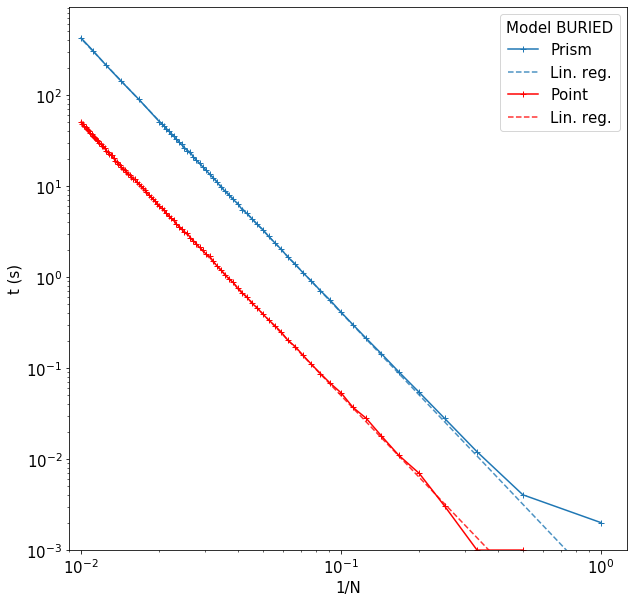

-3.3148785232959233
-4.287439096650178


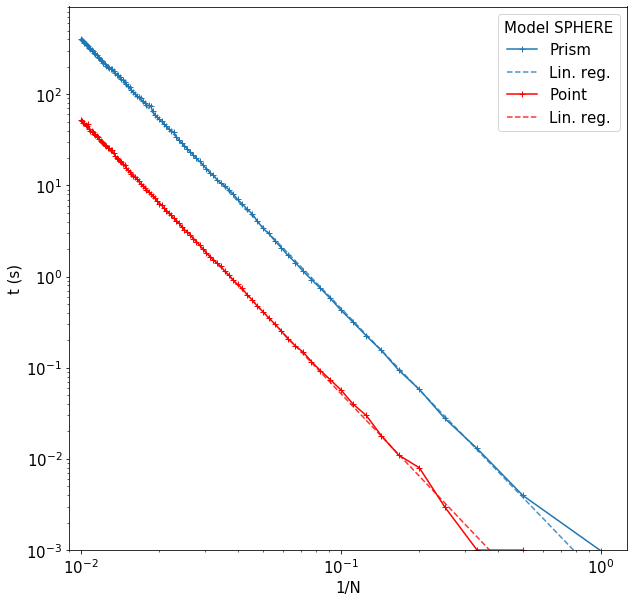

Average slope: [-2.99182592]


In [17]:
# This plots the timing results

# The list of N values that fit with the timing array
N_lijst = np.arange(1,101,1)

# The possible geometries
geometries = ["BURIED","SPHERE"]
# The possible methods
methods = ['prism','point']
# Two colours to use for the methods
colours = ['#1f77b4','r']

# Starting the average slope of the line fits
avg_slope = 0

# There should be two plots for both geometries
for geometry in geometries:
    plt.figure(figsize=(10,10))
    plt.rc('font', size=15)
    clr_id = 0
    # And two lines for the methods
    for method in methods:
        # Load the correct array for the data
        timing_plot = np.load("./saved arrays/%s - Recorded times - %s.npy" %(geometry,method))
        
        # When using the data, only the values that are not zero are used. Entries with zero have not been determined yet.
        
        # Convert the data to log for the linear regression
        log_space = np.log10(timing_plot[timing_plot > 0][10:])
        # The linreg with the data in log space
        lin_reg = LinearRegression().fit(np.log10(1/N_lijst[timing_plot > 0][10:]).reshape(-1,1), log_space)
        # The slope resulting from this
        coef = lin_reg.coef_
        avg_slope+=coef
        # The intercept of the line
        intercept = lin_reg.intercept_
        print(intercept)
        # Plot the data
        plt.plot(1/N_lijst[timing_plot > 0],timing_plot[timing_plot > 0],color = colours[clr_id], marker='+', label = 'P'+method[1:])
        # Plot the linear regression
        plt.plot(1/N_lijst,(np.power(1/N_lijst,coef)*10**intercept).reshape(-1,1), ls='--',color = colours[clr_id],alpha = 0.8, label = "Lin. reg.")
        
        plt.xlabel("1/N")
        plt.ylabel("t (s)")
        plt.grid(which = "both")
        plt.xscale("log")
        plt.yscale("log")
        clr_id += 1
    plt.legend(title="Model %s" %geometry)
    plt.xlim(left = 0.9* 1e-2)
    plt.ylim(bottom = 1e-3)
    # Save the figure as a png
    plt.savefig('./Results/timing_%s.png' %geometry, dpi=200)
    # Showing it
    plt.show()

# Calculating the average slope
avg_slope /= 4
print("Average slope:",avg_slope)

# Relative error

In [45]:
# This cell calculates the relative error of every gravity variable for a chosen method, model and set of N values

method = "prism" # can be point or prism
geometry = "BURIED" # can be SPHERE or BURIED
N_list = np.linspace(1,10,10) # N_list is an array that contains all the values of N you want to use

#N_list = np.empty(55)
#N_list[0:50] = np.linspace(1,50,50)
#N_list[50:] = np.linspace(60,100,5)

##########################################
##########################################

# The arrays are saved and need to be loaded. If they do not exist, new ones are created
try:
    errors_U = np.load("./saved arrays/%s - Recorded errors - U - %s.npy" %(geometry,method))
except FileNotFoundError:
    errors_U = np.zeros([100], dtype=np.float64)
try:
    errors_g = np.load("./saved arrays/%s - Recorded errors - g - %s.npy" %(geometry,method))
except FileNotFoundError:
    errors_g = np.zeros([100,3], dtype=np.float64)
try:
    errors_T = np.load("./saved arrays/%s - Recorded errors - T - %s.npy" %(geometry,method))
except FileNotFoundError:
    errors_T = np.zeros([100,3,3], dtype=np.float64)

start = time.time()

# Setting up the geometry depending on what model is selected
if geometry == "BURIED":
    R = 1000 # dimensions of the box as a cube [m]
    R_buried = 200 # dimensions of the buried prism as a cube [m]
    buried_depth = 100 # distance between top of the buried prism and the top of the box [m]
    rho0 = 2500 # density of the buried prism [kg/m^3]
    rho1 = 2600 # density of the surroundings [kg/m^3]
    
    # These comparisons are done with a single observation point just above the surface
    obs_point = np.array([0.5*R,0.5*R,R+.1])

if geometry == "SPHERE": 
    R = 6.371e6 # radius of the sphere [m]
    rho0 = 3000 # density of the sphere if hom is selected [kg/m^3]
    density_struc = "hom" # density structure that is used, can be hom, PREM or AK135
    
    # These comparisons are done with a single observation point at 100 m above the surface
    obs_point = np.array([0,0,R+100])
    
end_setup = time.time() - start
print("Done with first set-up at", end_setup, "s")

# Using every value of N
for N in N_list:
    start_loop = time.time()
    
    N = int(N)
    
    # Calculating the gravitational response according to every method. The analytical solution is calculated too
    if geometry == "BURIED":
        U,g,T = full_buried_calc(N,obs_point[np.newaxis,:],method,R,R_buried,buried_depth,rho0,rho1)
        U_th,g_th,T_th = grav_calc_analyt_buried(R,R_buried,buried_depth,obs_point[np.newaxis,:],rho0,rho1)
    
    if geometry == "SPHERE":
        U,g,T = full_sphere_calc(N,obs_point[np.newaxis,:],method,density_struc,rho0)
        U_th,g_th,T_th = grav_calc_analyt_sphere(obs_point[np.newaxis,:],rho0)
        
    # With the calculated values and the analytical solution the relative error can be determined. Some values will
    # give an error, because some of the analytical values are 0.
    errors_U[int(N-1)] = ((U - U_th) / U_th)
    errors_g[int(N-1),:] = ((g - g_th) / g_th)
    errors_T[int(N-1),:,:] = ((T - T_th) / T_th)
    
    print("Done with N =", N, "at", time.time() - start, "s, the relative error is", errors_g[int(N-1),2])

# The arrays are saved again
np.save("./saved arrays/%s - Recorded errors - U - %s.npy" %(geometry,method), errors_U) 
np.save("./saved arrays/%s - Recorded errors - g - %s.npy" %(geometry,method), errors_g)
np.save("./saved arrays/%s - Recorded errors - T - %s.npy" %(geometry,method), errors_T) 

duration = round(time.time() - start, 5)
print("Runtime: " + str(duration) + "s")

Done with first set-up at 0.0 s
Done with N = 1 at 0.0030012130737304688 s, the relative error is -0.0028946010479441505
Done with N = 2 at 0.008022546768188477 s, the relative error is -0.002894601047944275
Done with N = 3 at 0.023999452590942383 s, the relative error is 0.010394529830357916
Done with N = 4 at 0.05152130126953125 s, the relative error is -0.0028946010479439007
Done with N = 5 at 0.10752177238464355 s, the relative error is 0.006422111712924386


D:\Anaconda\lib\site-packages\ipykernel_launcher.py:71: RuntimeWarning: invalid value encountered in true_divide
D:\Anaconda\lib\site-packages\ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in true_divide


Done with N = 6 at 0.21352171897888184 s, the relative error is 0.00047335959032976415
Done with N = 7 at 0.35988569259643555 s, the relative error is -0.0019329954612436284
Done with N = 8 at 0.5629744529724121 s, the relative error is -0.00036912513951851885
Done with N = 9 at 0.8508787155151367 s, the relative error is -0.0018744757678226499
Done with N = 10 at 1.244882583618164 s, the relative error is 2.3708036178836956e-15
Runtime: 1.27283s


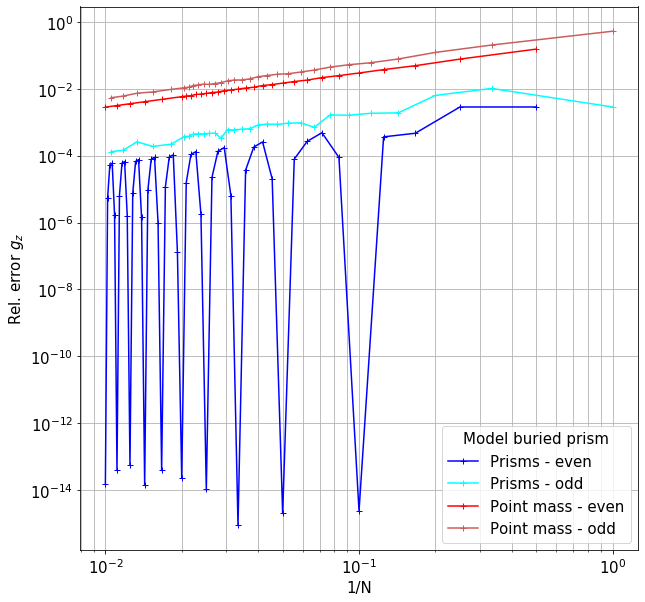

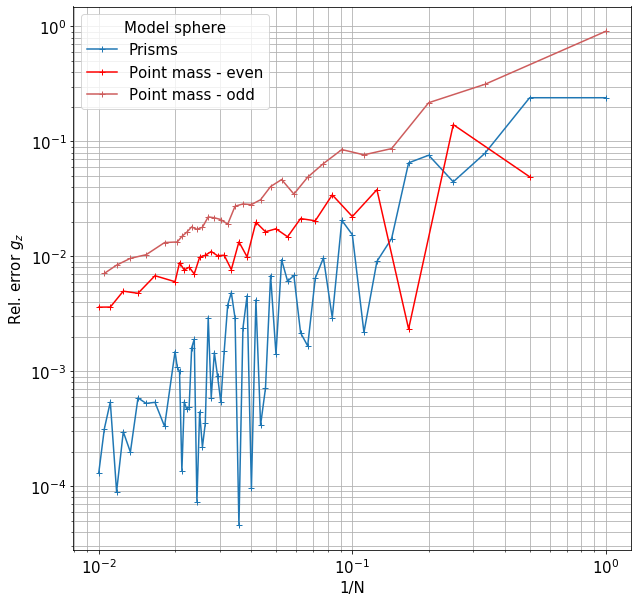

In [63]:
# This cell creates plots with the relative error of the different models and methods

# Setting up the values of N
N_lijst = np.arange(1,101,1)
# Loading the errors in from g
error_temp1 = np.load("./saved arrays/BURIED - Recorded errors - g - prism.npy")
error_temp2 = np.load("./saved arrays/BURIED - Recorded errors - g - point.npy")

# The relative error shown is of the component g_z
error_plot1 = error_temp1[:,2]
error_plot2 = error_temp2[:,2]

# The absolute versions of the relative error are used. The values that are zero are excluded, because it is assumed that
# due to small computation errors this will never happen. This means that zeros are the values that have not been 
# calculated yet.

plt.figure(figsize=(10,10))
plt.rc('font', size=15)
# The prism errors are split into the even and odd parts
plt.plot(1/N_lijst[1::2][error_plot1[1::2] != 0],abs(error_plot1[1::2][error_plot1[1::2] != 0]), color = "b", marker='+', label = "Prisms - even")
plt.plot(1/N_lijst[::2][error_plot1[::2] != 0],abs(error_plot1[::2][error_plot1[::2] != 0]), color = "cyan",marker='+', label = "Prisms - odd")
# The point mass errors are also split into even and odd
plt.plot(1/N_lijst[1::2][error_plot2[1::2] != 0],abs(error_plot2[1::2][error_plot2[1::2] != 0]), marker='+', color = "r", label = "Point mass - even")
plt.plot(1/N_lijst[::2][error_plot2[::2] != 0],abs(error_plot2[::2][error_plot2[::2] != 0]), marker='+', color = "indianred", label = "Point mass - odd")
plt.xlabel("1/N")
plt.ylabel("Rel. error $g_z$")
plt.grid(which = "both")
plt.legend(title = "Model buried prism")
plt.xscale("log")
plt.yscale("log")
plt.savefig('./Results/errors_buried.png', dpi=200)
plt.show()

# The same process is repeated for the sphere model.
error_temp1 = np.load("./saved arrays/SPHERE - Recorded errors - g - prism.npy")
error_temp2 = np.load("./saved arrays/SPHERE - Recorded errors - g - point.npy")

error_plot1 = error_temp1[:,2]
error_plot2 = error_temp2[:,2]

plt.figure(figsize=(10,10))
plt.rc('font', size=15)
plt.plot(1/N_lijst[error_plot1 != 0],abs(error_plot1[error_plot1 != 0]), marker='+', label = "Prisms")
plt.plot(1/N_lijst[1::2][error_plot2[1::2] != 0],abs(error_plot2[1::2][error_plot2[1::2] != 0]), marker='+', color = "r", label = "Point mass - even")
plt.plot(1/N_lijst[::2][error_plot2[::2] != 0],abs(error_plot2[::2][error_plot2[::2] != 0]), marker='+', color = "indianred", label = "Point mass - odd")
plt.xlabel("1/N")
plt.ylabel("Rel. error $g_z$")
plt.grid(which = "both")
plt.legend(title = "Model sphere")
plt.xscale("log")
plt.yscale("log")
plt.savefig('./Results/errors_sphere.png', dpi=200)
plt.show()

# Using an observation grid

In [18]:
# Choose the geometry that is used for the plot
geometry = "SPHERE" # can be SPHERE or BURIED

# The times are loaded in to give an indication of the time needed. 
times_prism = np.load("./saved arrays/%s - Recorded times - prism.npy" %(geometry))
times_point = np.load("./saved arrays/%s - Recorded times - point.npy" %(geometry))

# Put in the desired values of N and M. N represents the amount of cells per axis, while M describes the amount of 
# observation points. M determines the amount of pixels on the plot and N the resolution of the model. The plot will be
# MxM pixels. 
N = 15
M = 50

# Based on the settings an expected duration is given. This uses the data gotten in the timing. 
expected = times_prism[N-1] * M**2 + times_point[N-1] * M**2
print(times_prism[N-1], "+", times_point[N-1])

print("Expected duration of calculations:")
time_converter(expected)

1.4269764423370361 + 0.17400097846984863
Expected duration of calculations:
1 h. 6 m. 42.44355 s.


In [14]:
start = time.time()

G = 6.6738480e-11 # gravitational constant [m^3 s^-2 kg^-1]

if geometry == "SPHERE":
    R = 6.371e6 # radius of the sphere [m]
    rho0 = 3000 # density if hom density structure is selected [kg/m^3]
    density_struc = "hom" # can be hom for homogeneous, AK135 for the density model of the same name, PREM similar
    # The observation points lie in a horizontal plane above the surface of the sphere. This determines the distance from  
    # the surface of that plane
    dist_surface = 1000
    
    # The coordinates of the observation point, in the same plane with z=R+dist_surface
    x = np.linspace(-R,R,M)
    y = np.linspace(-R,R,M)
    z = R+dist_surface

if geometry == "BURIED":
    R = 1000 # 200  # The size of the box [m]
    R_buried = 200 # The size of the buried prism [m]
    buried_depth = 100 # 0 # Distance between the top of the buried prism and the top of the box [m]
    rho0 = 2500 # Density of the surrounding material [kg/m^3]
    rho1 = 2600 # Density of the buried prism [kg/m^3]
    
    dist_surface = 100 # -R - 100 # Distance between the surface of the box and the observation grid
    
    extra = 0 # (1000 - R)/2 # If you want the observation grid to expand beyond the box. This is the extent on each side
    
    # The coordinates of the observation point, in the same plane with z=R+dist_surface
    x = np.linspace(-extra,R+extra,M)
    y = np.linspace(-extra,R+extra,M)
    z = R + dist_surface
    
# The amount of observation points. M is similar to N, it determines the amount of observation points on one axis. Because
# the observations are all in the same plane, the total amount of observation points is M^2 (MP). 
MP = M**2

obs_points = np.zeros([MP,3])

counter = 0
for j in range(M):
    for k in range(M):
        obs_points[counter,0] = x[j]
        obs_points[counter,1] = y[k]
        obs_points[counter,2] = z
        counter += 1

print("Done with setting up observation points at", time.time() - start, "s")

# If N is smaller than 15, the print function can often not keep up and starts printing without clearing the last output
tracking = N >= 15

# The calculations with prisms are done
if geometry == "SPHERE":
    U,g,T = full_sphere_calc(N,obs_points,'prism',density_struc, rho0, tracking = tracking)
elif geometry == "BURIED":
    U,g,T = full_buried_calc(N,obs_points,'prism',R,R_buried,buried_depth,rho0,rho1)
# The results are reformed into the right size for imshow
U = np.reshape(U,(M,M))
g = np.reshape(g,(M,M,3))
T = np.reshape(T,(M,M,3,3))

# The arrays are saved, so they can just be loaded in another time
np.save("./saved arrays/%s_array_U_N_%s_M_%s_prism" %(geometry, N, M), U)
np.save("./saved arrays/%s_array_g_N_%s_M_%s_prism" %(geometry, N, M), g)
np.save("./saved arrays/%s_array_T_N_%s_M_%s_prism" %(geometry, N, M), T)

print("Done with prism calculations at", time.time() - start)

# The calculations with point masses are done
if geometry == "SPHERE":
    U_point,g_point,T_point = full_sphere_calc(N,obs_points,'point',density_struc, rho0, tracking = tracking)
elif geometry == "BURIED":
    U_point,g_point,T_point = full_buried_calc(N,obs_points,'point',R,R_buried,buried_depth,rho0,rho1)
    
U_point = np.reshape(U_point,(M,M))
g_point = np.reshape(g_point,(M,M,3))
T_point = np.reshape(T_point,(M,M,3,3))

np.save("./saved arrays/%s_array_U_N_%s_M_%s_point" %(geometry, N, M), U_point)
np.save("./saved arrays/%s_array_g_N_%s_M_%s_point" %(geometry, N, M), g_point)
np.save("./saved arrays/%s_array_T_N_%s_M_%s_point" %(geometry, N, M), T_point)

print("Done with point mass calculations at", time.time() - start)

# The calculations with the analytical solution are done
if geometry == "SPHERE":
    U_th, g_th, T_th = grav_calc_analyt_sphere(obs_points,rho0)
if geometry == "BURIED":
    U_th, g_th, T_th = grav_calc_analyt_buried(R,R_buried,buried_depth,obs_points,rho0,rho1)
U_th = np.reshape(U_th, (M,M))
g_th = np.reshape(g_th, (M,M,3))
T_th = np.reshape(T_th, (M,M,3,3))

duration = time.time() - start
print("Runtime: ")
time_converter(duration)
print("Relative error of expected timing value:", (expected-duration)/duration)

Done with setting up observation points at 0.004000186920166016 s
Done with prism calculations at 3302.094127893448
Tracking
Done with point mass calculations at 3638.8722767829895
Runtime: 
1 h. 0 m. 38.87228 s.
Relative error of expected value: 0.09086389079693674


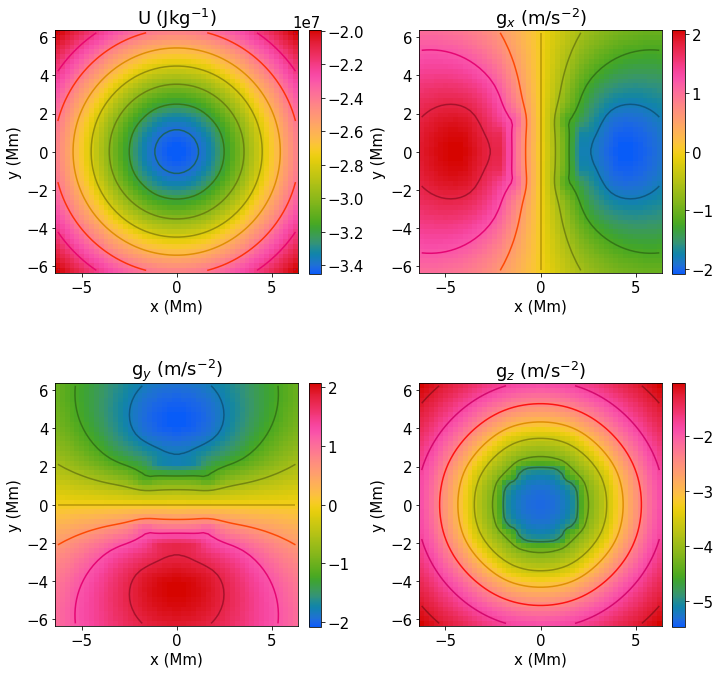

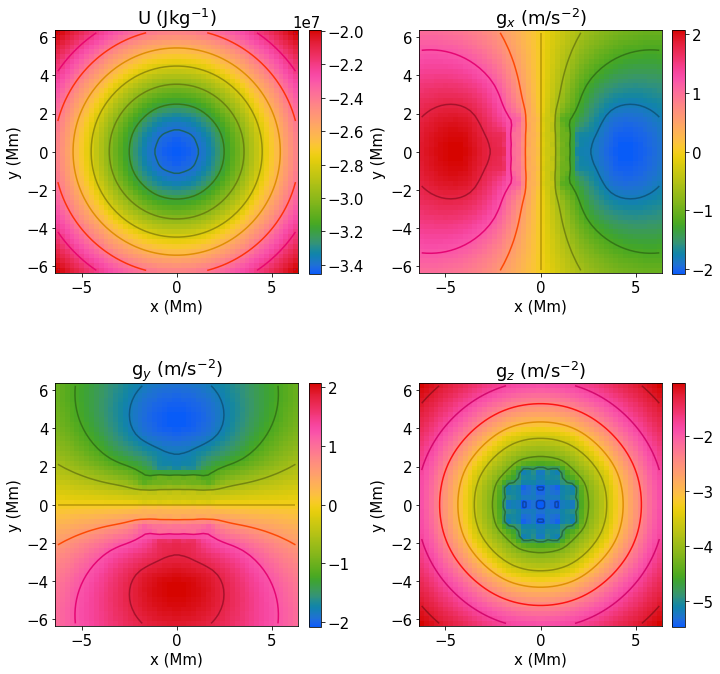

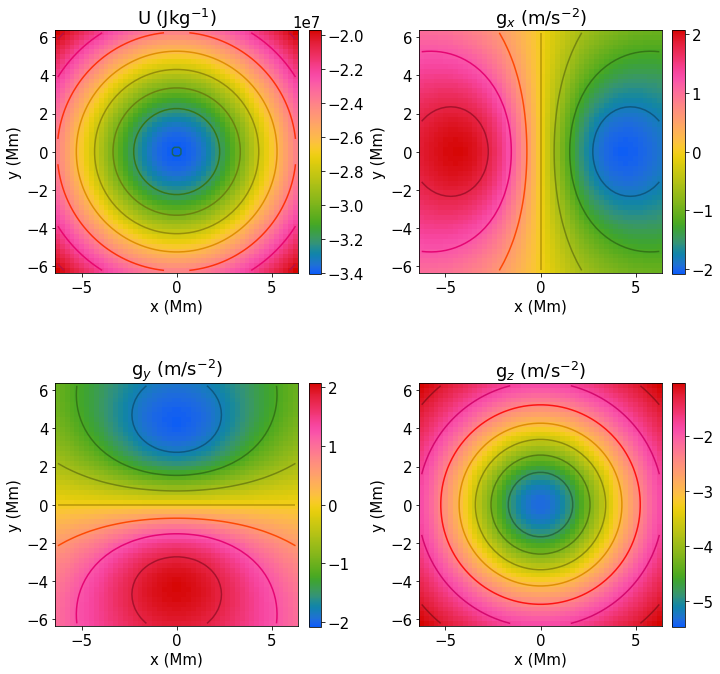

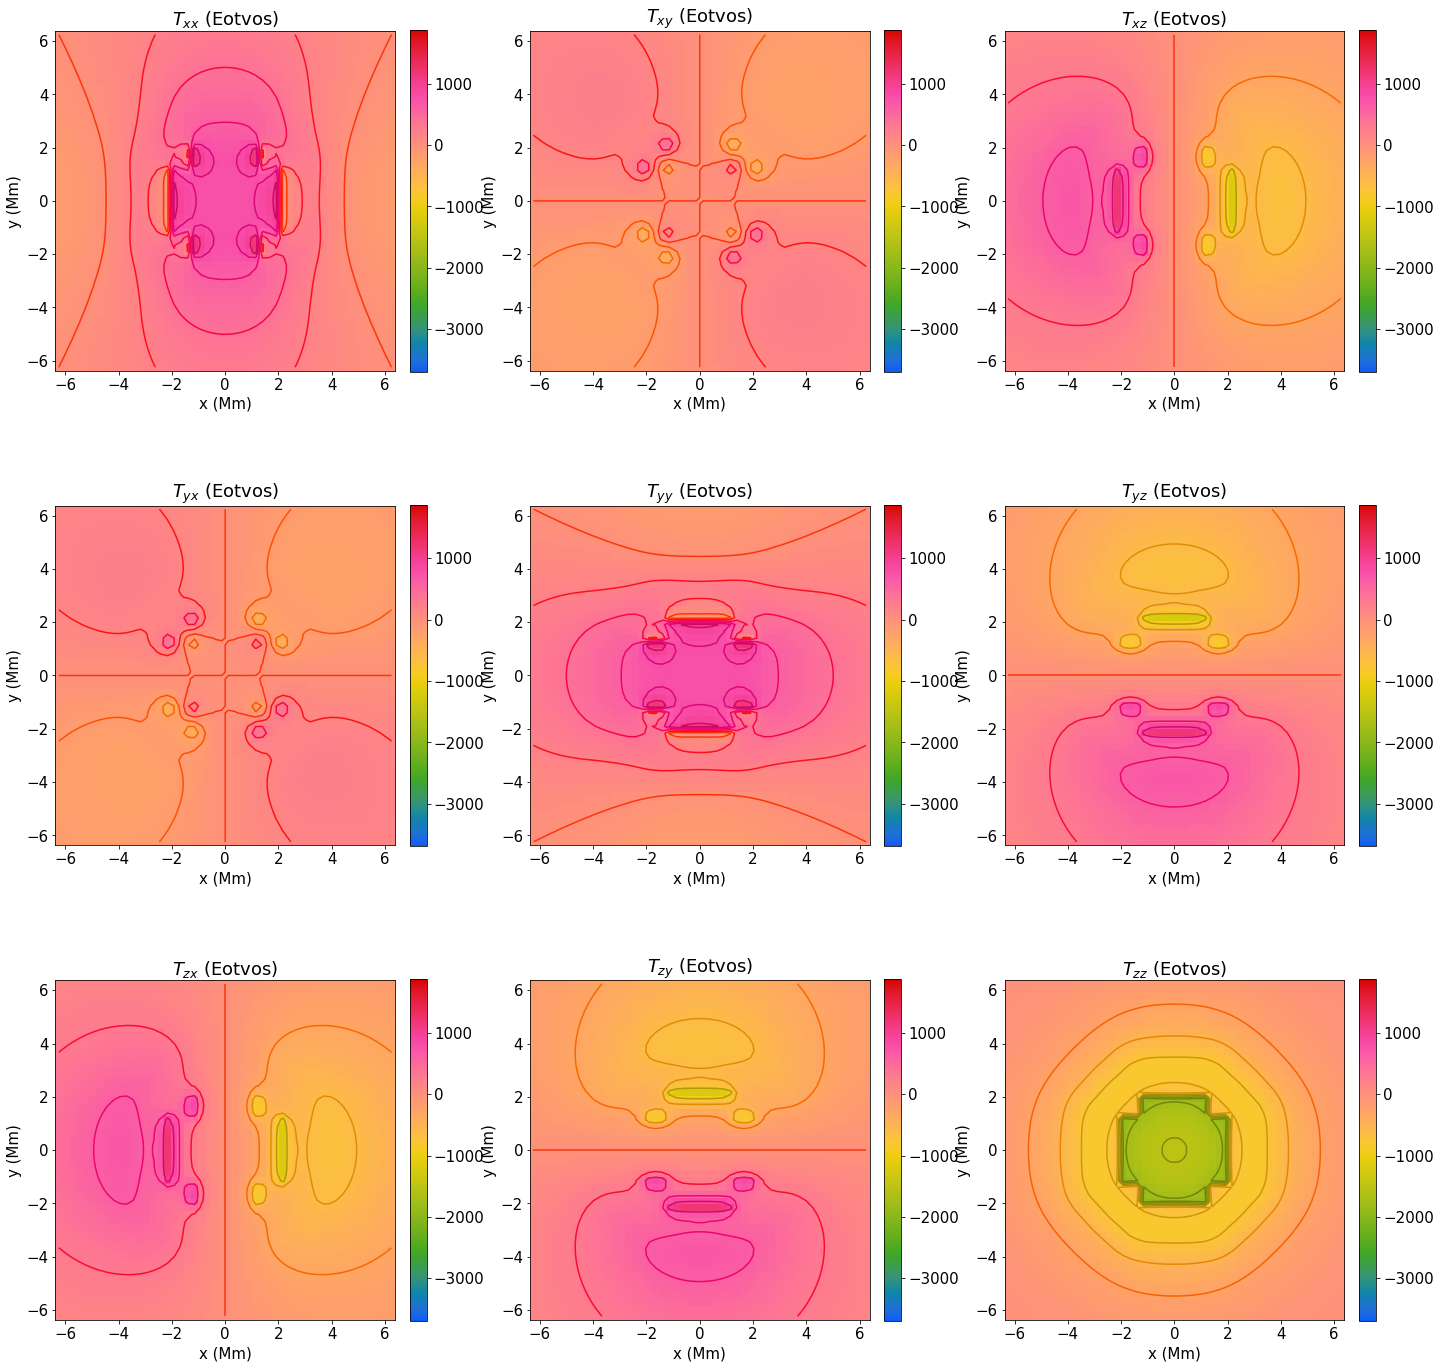

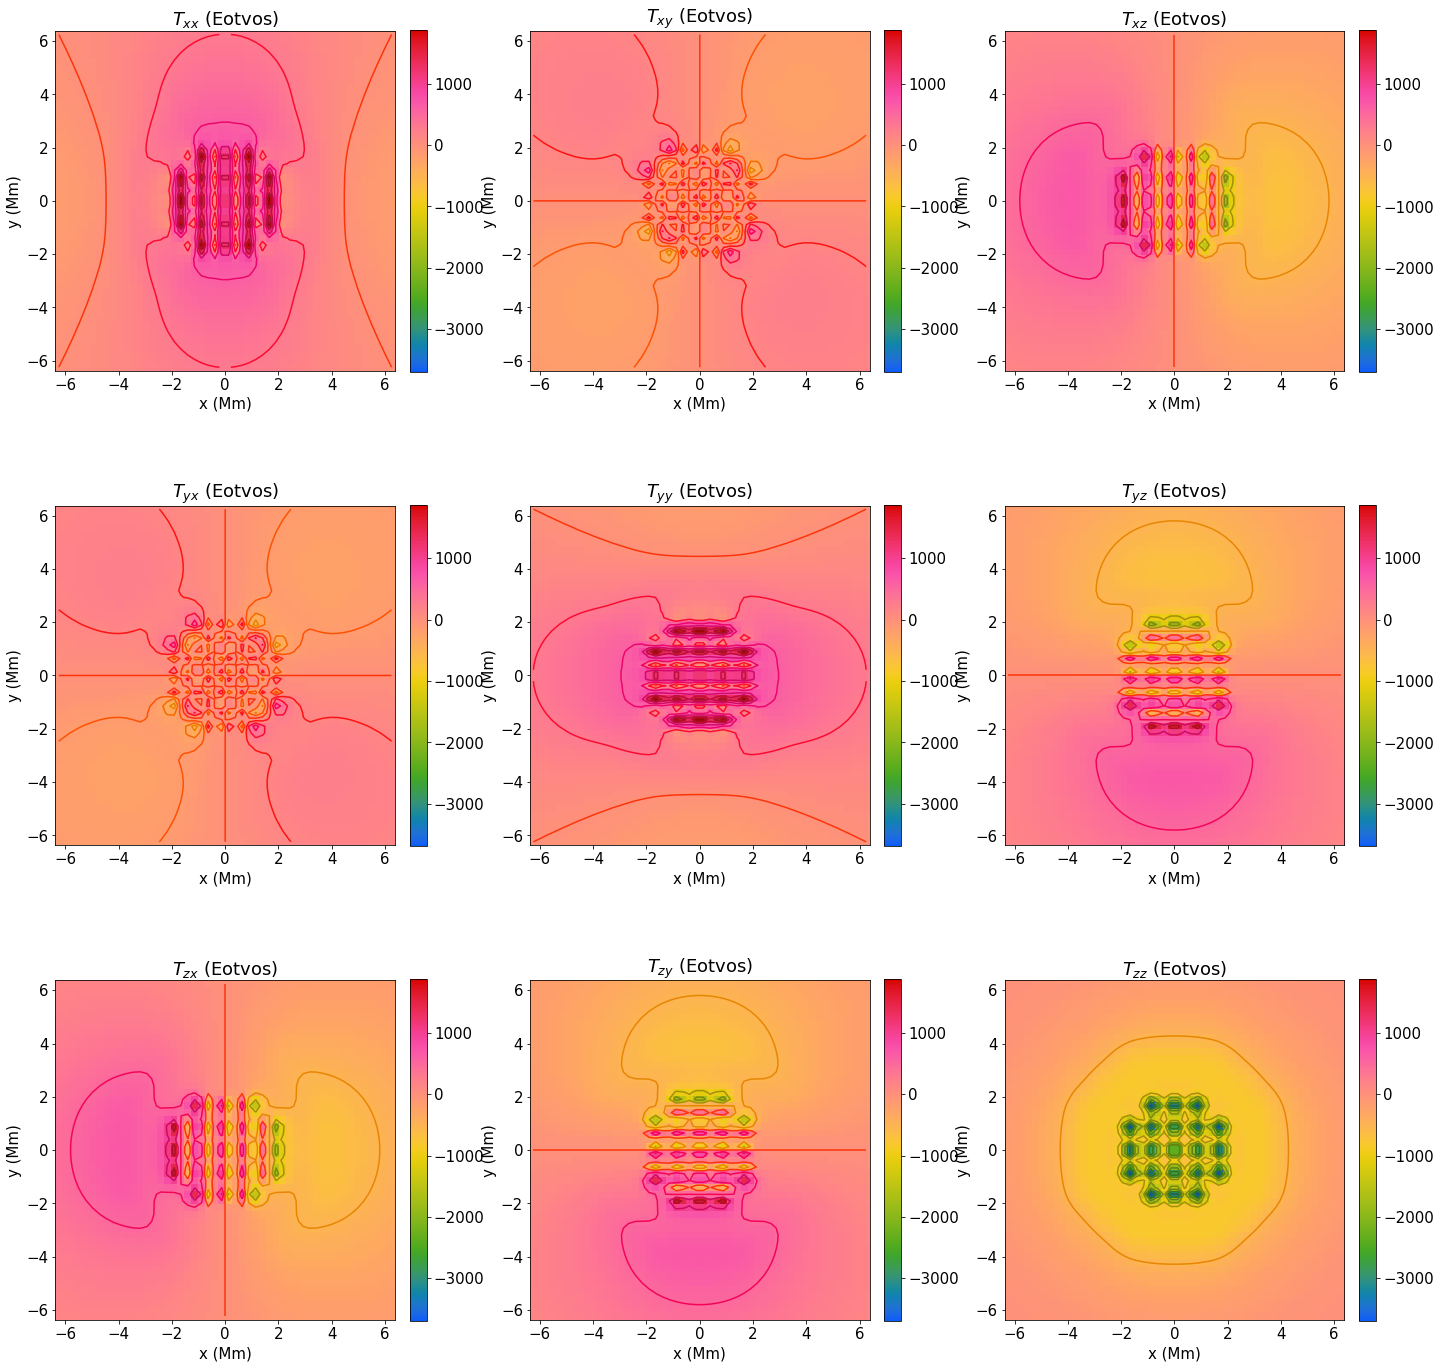

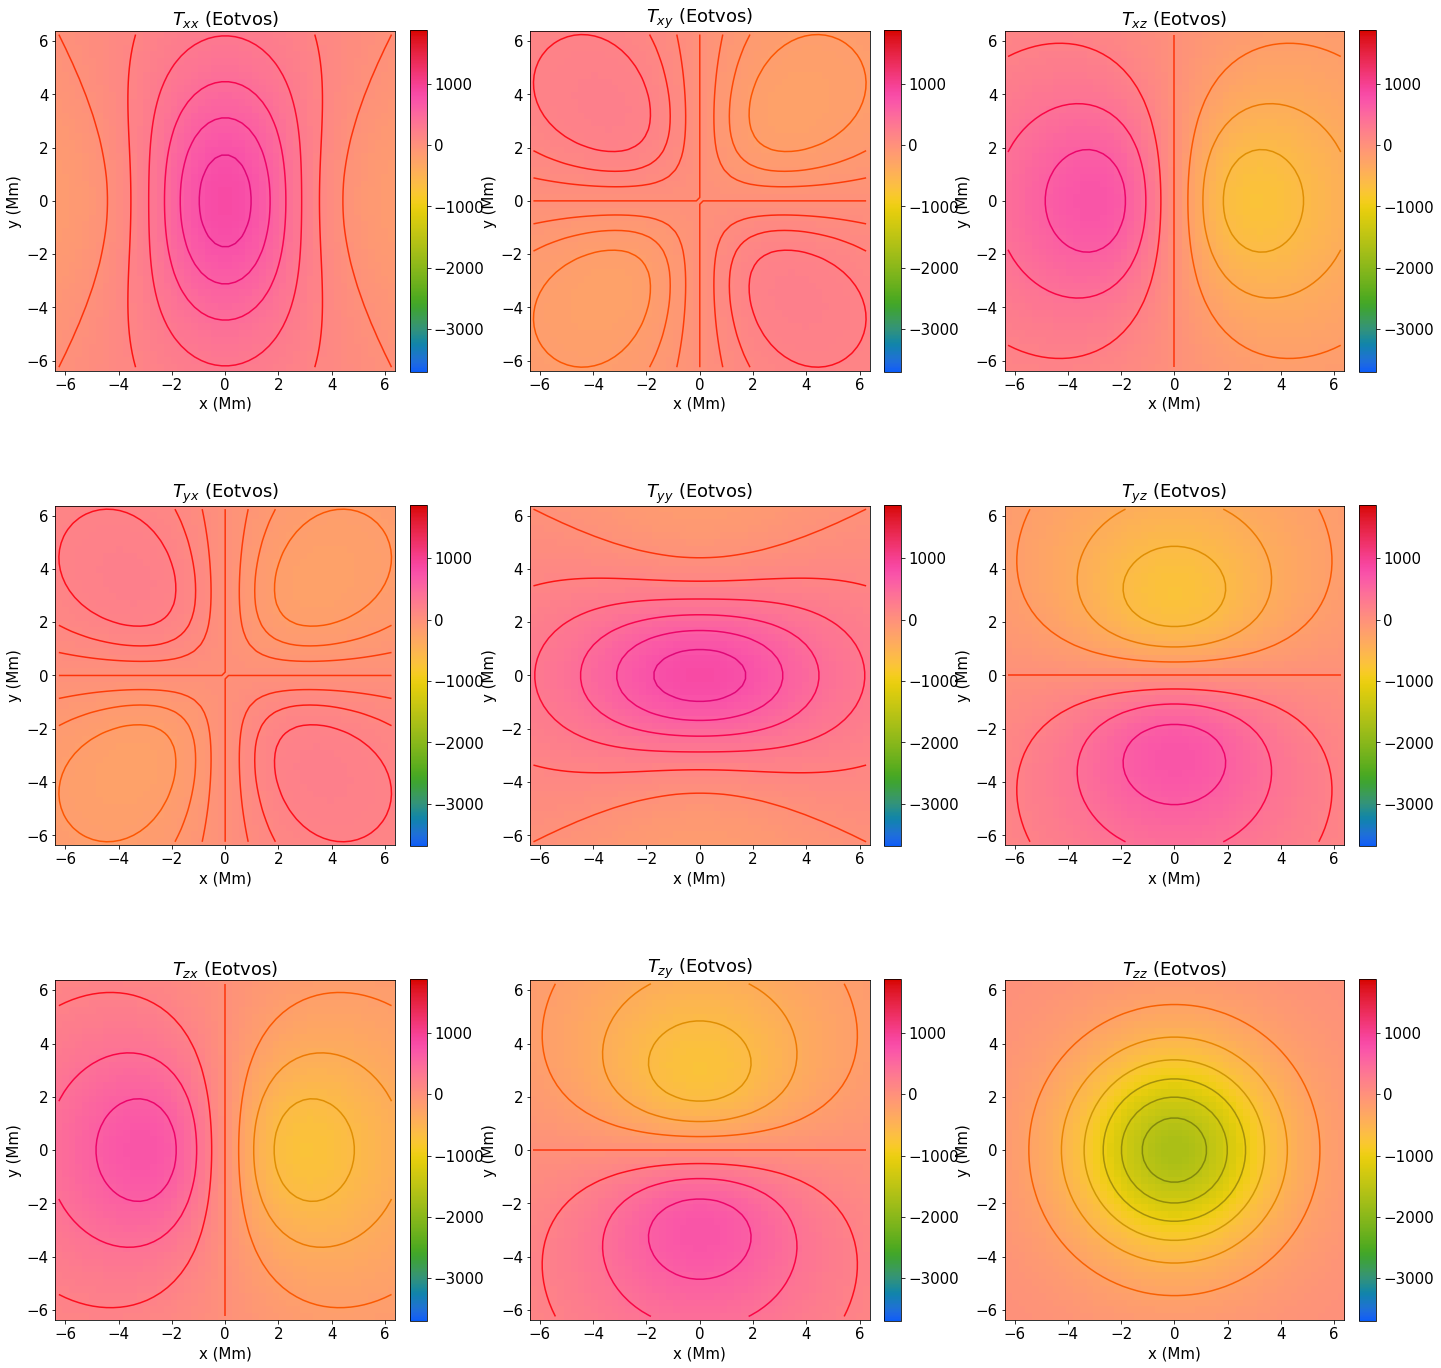

In [15]:
# The different variables are visualised in plots showing the observation plane. The colourmap used is visually homogeneous
# The range of colours is fixed for each of the plots of T from the minimum to the maximum value that T takes. This way
# the same colour means the same value. This is not fully done for g. The x and y components are on a different scale
# compared to the z-component. So the x and y are fixed and z is not. 
plt.rc('font', size=15)

colormap_used = "cet_diverging_rainbow_bgymr_45_85_c67" # cet_rainbow_bgyrm_35_85_c69_r

namen = ['x','y','z']

U_min,U_max = extreme_finder(U,U_point,U_th)
T_min,T_max = extreme_finder(T*1e9,T_point*1e9,T_th*1e9)
g_xy_min,g_xy_max = extreme_finder(g[:,:,0:2],g_point[:,:,0:2],g_th[:,:,0:2])
g_z_min,g_z_max = extreme_finder(g[:,:,2],g_point[:,:,2],g_th[:,:,2])

imshow_U_g(U,g,N,geometry,"prism",U_min=U_min,U_max=U_max,g_z_min=g_z_min,g_z_max=g_z_max,g_xy_min=g_xy_min,g_xy_max=g_xy_max)
imshow_U_g(U_point,g_point,N,geometry,"point",U_min=U_min,U_max=U_max,g_z_min=g_z_min,g_z_max=g_z_max,g_xy_min=g_xy_min,g_xy_max=g_xy_max)
imshow_U_g(U_th,g_th,N,geometry,"analytical",U_min=U_min,U_max=U_max,g_z_min=g_z_min,g_z_max=g_z_max,g_xy_min=g_xy_min,g_xy_max=g_xy_max)

imshow_T(T,N,geometry,"prism",T_min=T_min,T_max=T_max)
imshow_T(T_point,N,geometry,"point",T_min=T_min,T_max=T_max)
imshow_T(T_th,N,geometry,"analytical",T_min=T_min,T_max=T_max)

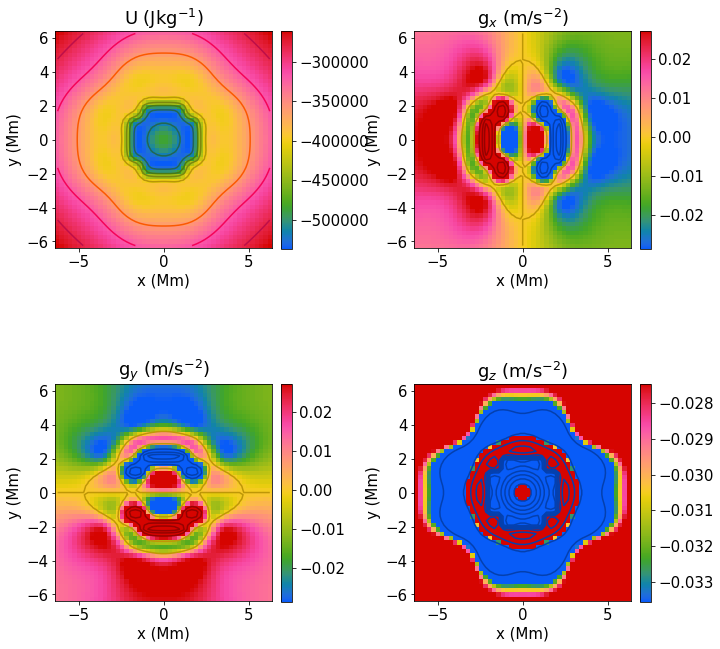

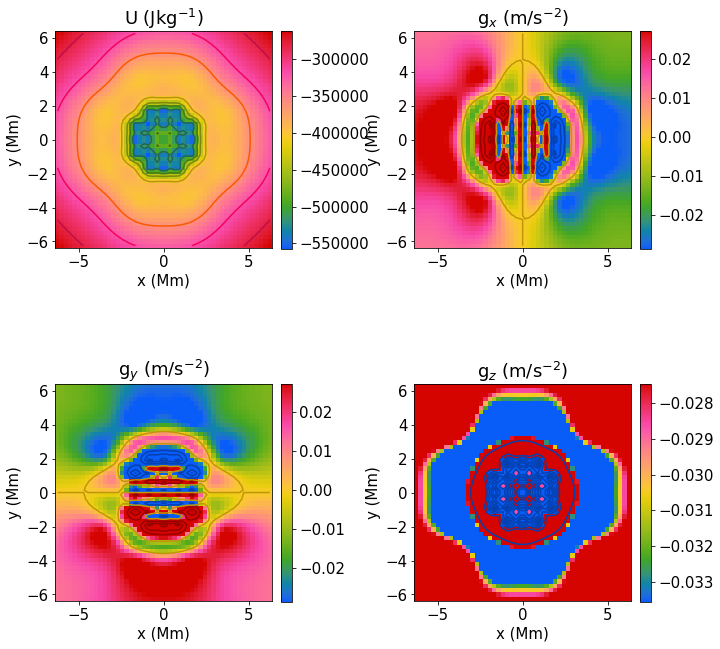

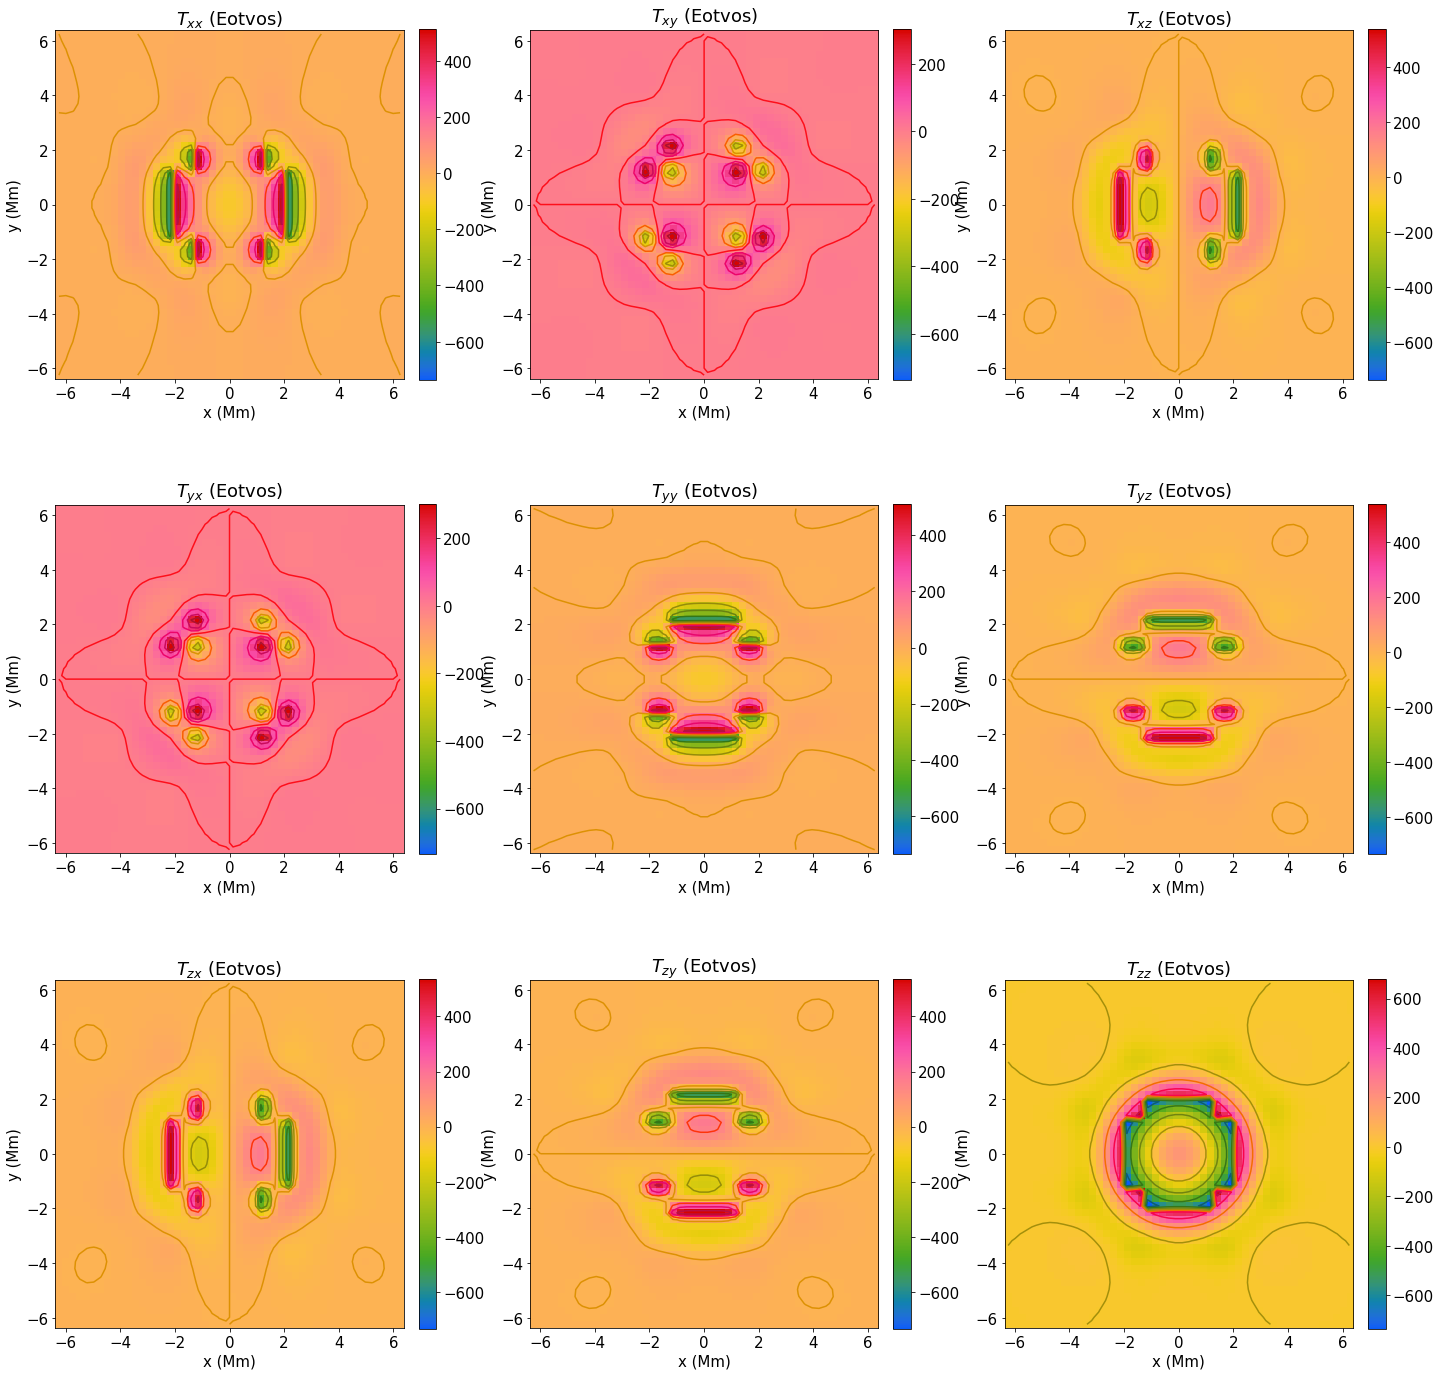

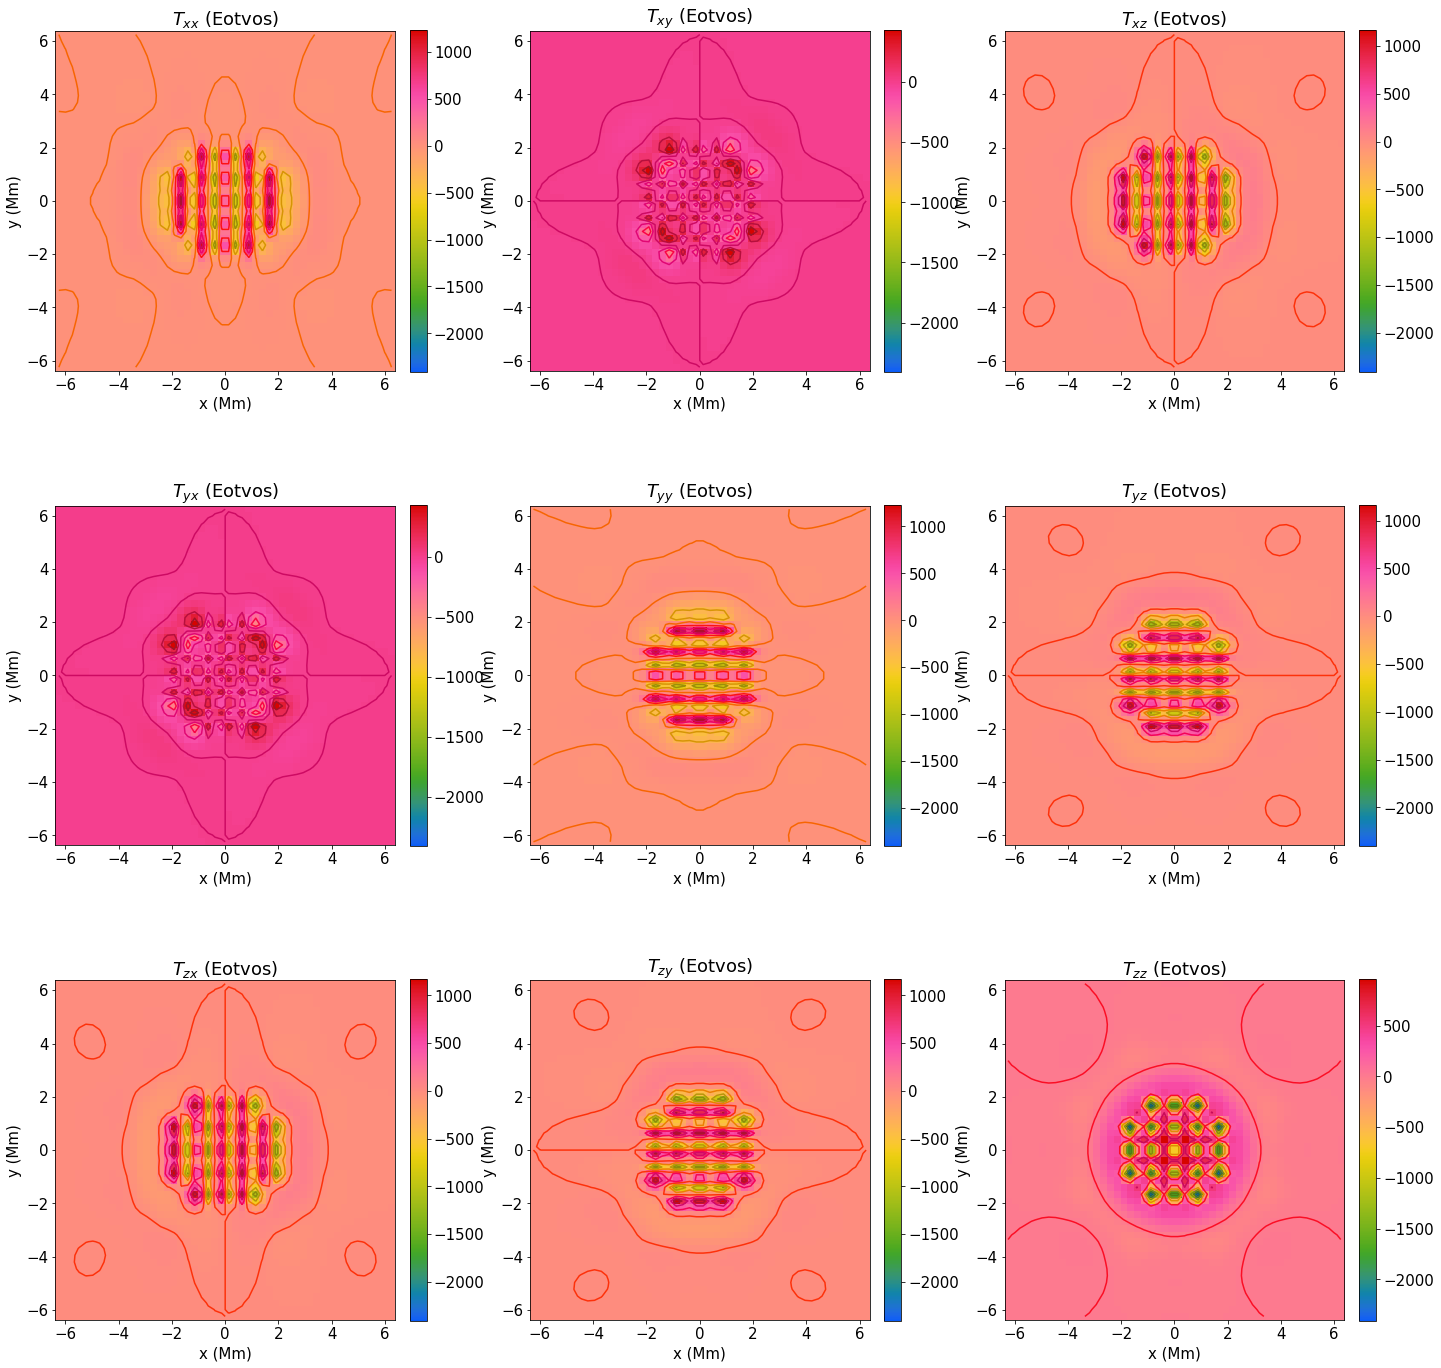

In [19]:
# The absolute error can also be interesting to show, especially when the relative error cannot be calculated. This is 
# simply calculated by subtracting the theoretical value from the calculated value.

U_abs_error_buried_prism = U - U_th
U_abs_error_buried_point = U_point - U_th

g_abs_error_buried_prism = g - g_th
g_abs_error_buried_point = g_point - g_th

T_abs_error_sphere_prism = T - T_th
T_abs_error_sphere_point = T_point - T_th

imshow_U_g(U_abs_error_buried_prism,g_abs_error_buried_prism,N,"SPHERE",'abs_error_prism')
imshow_U_g(U_abs_error_buried_point,g_abs_error_buried_point,N,"SPHERE",'abs_error_point')

imshow_T(T_abs_error_sphere_prism,N,geometry,'abs_error_prism')
imshow_T(T_abs_error_sphere_point,N,geometry,'abs_error_point')

# Salt diapir

In [19]:
# The data file is opened
data = open("salt_dome__153_98_70.vs",'r')
# Each line is converted to a string
data_read = data.readlines()

# Lists are created for each variable
cell = []
x = []
y = []
z = []
salt = []

# Each line is read
for line in data_read:
    # If the line starts with PVRTX, a cell is defined
    if line[0:5] == 'PVRTX':
        # The amount of spaces counted shows what variable is used
        number = 0
        
        cell_value = ""
        x_value = ""
        y_value = ""
        z_value = ""
        
        # Strings for every variable are built up
        for i in line:
            if i == " ":
                number += 1
            if number == 1:
                cell_value += i
            if number == 2:
                x_value += i
            elif number == 3:
                y_value += i
            elif number == 4:
                z_value += i
            elif number == 5:
                salt_value = i
        
        # Converted to numbers and added to their list
        cell.append(float(cell_value))
        x.append(float(x_value))
        y.append(float(y_value))
        z.append(float(z_value))
        salt.append(bool(int(salt_value)))
data.close()

In [21]:
# This is a piece of code frome Cedric that will convert the data to a format that paraview can use.
vtufile=open('markers_salt.vtu',"w")
vtufile.write("<VTKFile type='UnstructuredGrid' version='0.1' byte_order='BigEndian'> \n")
vtufile.write("<UnstructuredGrid> \n")
vtufile.write("<Piece NumberOfPoints=' %5d ' NumberOfCells=' %5d '> \n" %(nmarker,nmarker))
vtufile.write("<Points> \n")
vtufile.write("<DataArray type='Float32' NumberOfComponents='3' Format='ascii'>\n")
for i in range(0,nmarker):
    vtufile.write("%10e %10e %10e \n" %(x_salt[i],y_salt[i],z_salt[i]))
vtufile.write("</DataArray>\n")
vtufile.write("</Points> \n")
vtufile.write("<Cells>\n")
vtufile.write("<DataArray type='Int32' Name='connectivity' Format='ascii'> \n")
for i in range(0,nmarker):
    vtufile.write("%d " % i)
vtufile.write("</DataArray>\n")
vtufile.write("<DataArray type='Int32' Name='offsets' Format='ascii'> \n")
for i in range(0,nmarker):
    vtufile.write("%d " % (i+1))
vtufile.write("</DataArray>\n")
vtufile.write("<DataArray type='Int32' Name='types' Format='ascii'>\n")
for i in range(0,nmarker):
    vtufile.write("%d " % 1)
vtufile.write("</DataArray>\n")
vtufile.write("</Cells>\n")
vtufile.write("</Piece>\n")
vtufile.write("</UnstructuredGrid>\n")
vtufile.write("</VTKFile>\n")
vtufile.close()

In [44]:
rho_salt = 2200
rho_rock = 2600
method = 'prism'

######################################################
######################################################

start = time.time()

# The first step is to create a list with every possible value of the different coordinates
x_val = []
y_val = []
z_val = []

x_0 = None
y_0 = None
z_0 = None
# Every value is looked at. If it is different compared to the last one it is added to the list. When the loop restarts, 
# the new value is lower than the last one, so the program stops looking for new ones and removes the lower value.
for x_value in x:
    if x_value != x_0:
        x_val.append(x_value)
    if x_0 != None and x_value < x_0:
        x_val.pop()
        break
    x_0 = x_value

for y_value in y:
    if y_value != y_0:
        y_val.append(y_value)
    if y_0 != None and y_value < y_0:
        y_val.pop()
        break
    y_0 = y_value
    
for z_value in z:
    if z_value != z_0:
        z_val.append(z_value)
    if z_0 != None and z_value < z_0:
        z_val.pop()
        break
    z_0 = z_value

# With these lists the lengths of a cell on each axis can be determined
h_x = x_val[1]-x_val[0]
h_y = y_val[1]-y_val[0]
h_z = (z_val[1]-z_val[0])

# The size of the total box can be determined
R_x = x[-1] + h_x
R_y = y[-1] + h_y
R_z = z[-1] + h_z

# The amount of cells is determined
NP = len(x)

# The lists of coordinates are put into an array of the right shape for the program
corners = np.empty([NP,3],dtype=np.float64)
for i in range(len(corners)):
    corners[i,0] = x[i]
    corners[i,1] = y[i]
    corners[i,2] = R_z-z[i] - h_z

# An alternative mode exists where only the cells where there is salt are used. 
corners_alt = corners[salt]

# Everywhere where there is salt, the density is the relative density of salt compared to the rock, everywhere else it is
# zero. 
rho = np.where(salt,rho_salt-rho_rock,0)

# In the alternative version where only the salt cells are used, the density is the same everywhere of course. 
rho_alt = rho[salt]

# Because the space is not square, the observation grid will also be deformed, except if the right proportions are used.
# This implementation is not ideal yet. I need to take a second look at it, but it works for now. 
M = 15
ratio = R_x/R_y
M_x = int(np.round(M*ratio,0))
M_y = M
MP = int(M_x*M_y)
obs_points = np.empty([MP,3], dtype = np.float64)
obs_x = np.linspace(0,R_x,M_x)
obs_y = np.linspace(0,R_x,M_y)

counter = 0
for i in range(M_x):
    for j in range(M_y):
        obs_points[counter,0] = obs_x[i]
        obs_points[counter,1] = obs_y[j]
        obs_points[counter,2] = R_z+1
        counter += 1

print("Done with set-up at", time.time() - start, "s")

# The gravitational response is recorded with the given corners, densities and observation points.
U,g,T = full_calc(corners_alt,obs_points,method,rho_alt,h_x,h_y,h_z, tracking = True)
#full_calc(corners,obs_points,'point',rho,h_x,h_y=None,h_z=None, tracking = False)

# The results are reshaped to fit the observation grid
U = np.reshape(U, (M_x,M_y))
g = np.reshape(g, (M_x,M_y,3))
T = np.reshape(T, (M_x,M_y,3,3))

# and saved
np.save("Salt dome M %sx%s - U" %(M_x,M_y), U)
np.save("Salt dome M %sx%s - g" %(M_x,M_y), g)
np.save("Salt dome M %sx%s - T" %(M_x,M_y), T)

print("Runtime:", time.time() - start, 's')

Done with set-up at 1.562293291091919 s


KeyboardInterrupt: 

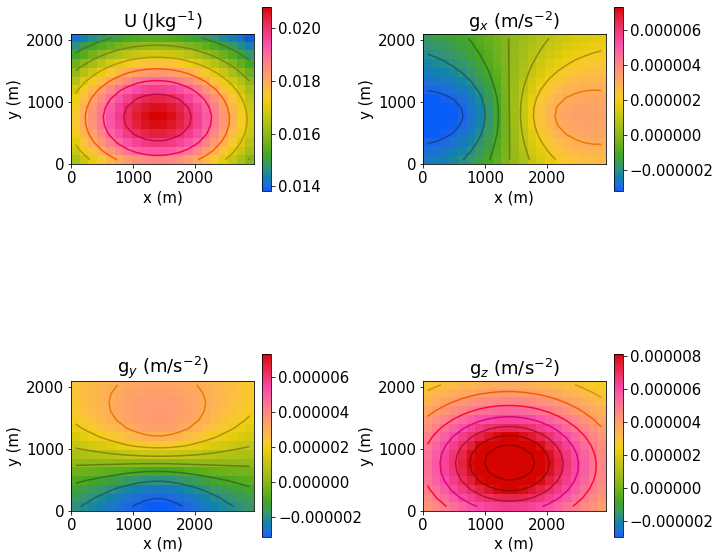

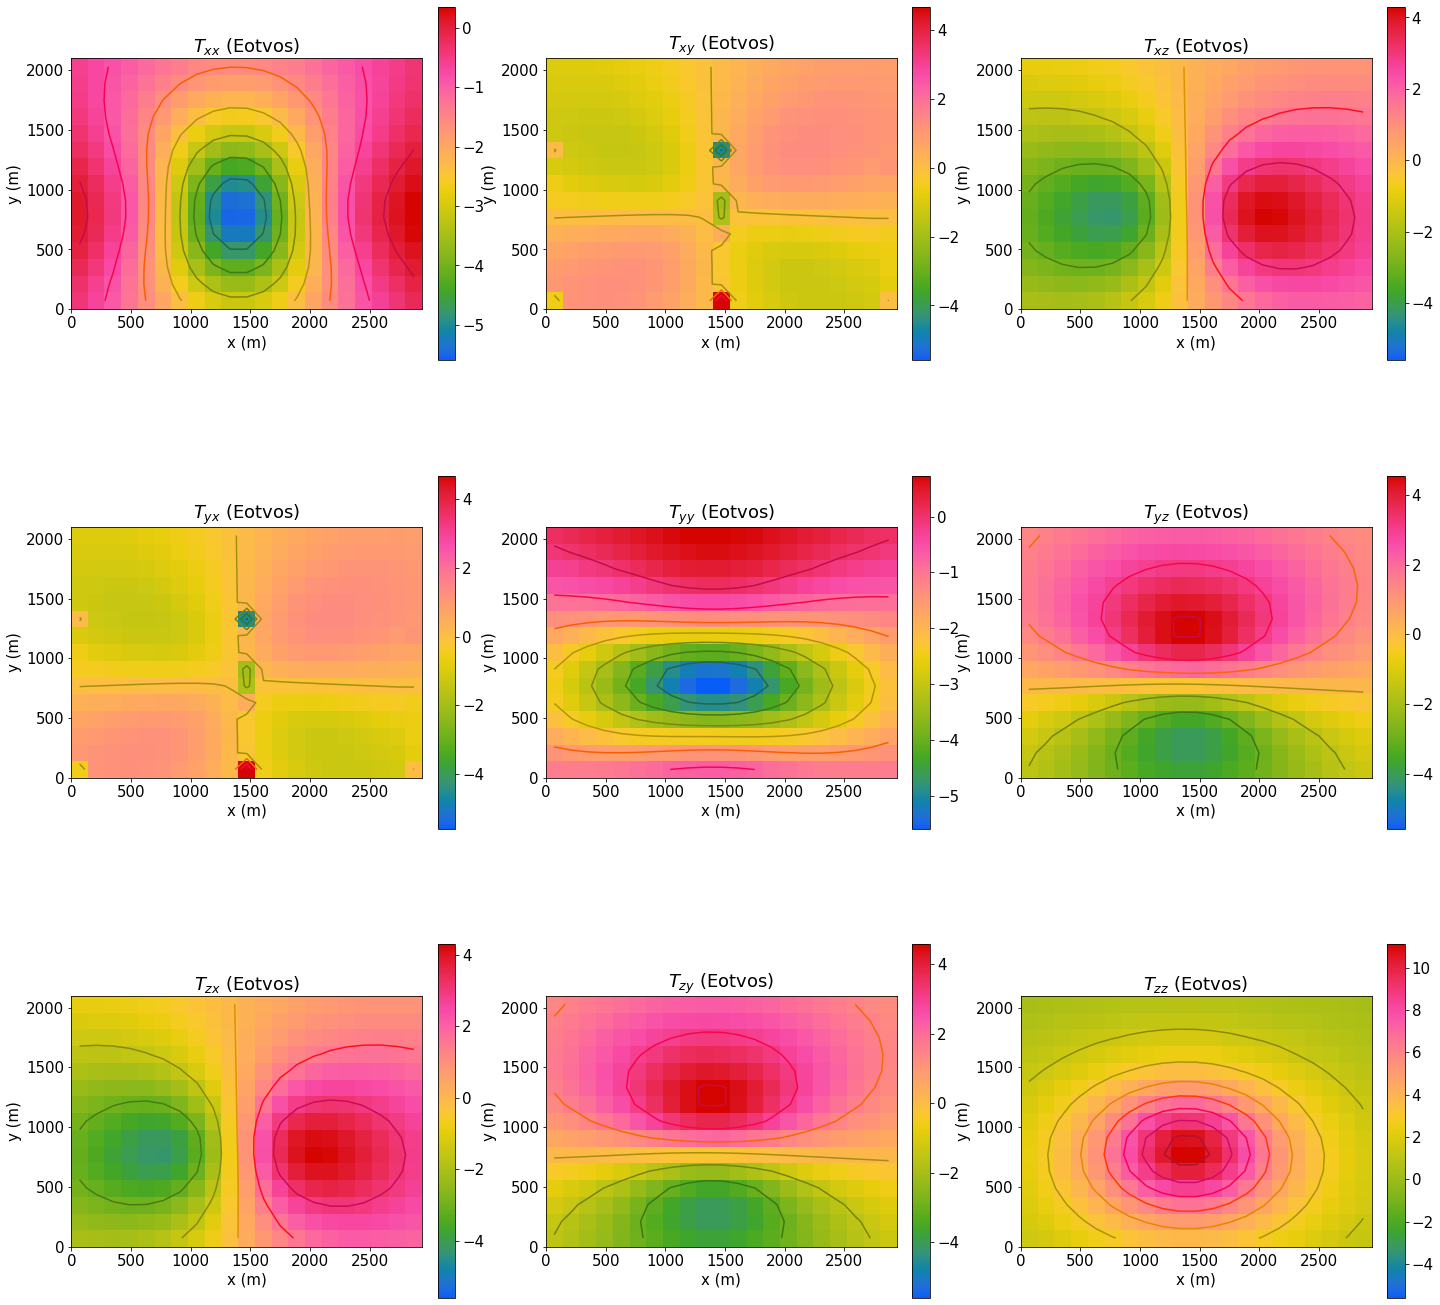

In [30]:
# Show the results
imshow_U_g(U,g,N_x,'SALT','Salt dome')
imshow_T(T,N_x,'SALT','Salt dome')